In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import math

import plotly.express as px

import pandas_datareader.data as web

from keras.callbacks import EarlyStopping

import keras
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.metrics import mean_squared_error

Using Theano backend.


## Introduction
Technical analysis is a trading discipline used to evaluate investments and identify trading opportunities in price trends and patterns from graphs.  Technical analysts believe past trading activity and price changes of a stock can be indicators of the security's future price movements.  The difference between 
technical analysis and fundamental analysis is that fundamental analysts focuses on a company's financials rather than historical price patterns or stock trends.  https://www.investopedia.com/terms/t/technicalanalysis.asp<br>
This notebook will demonstrate how to perform a basic technical analysis of stock prices using Python code.  I will provide analysis and insights of stock prices that can be obtained from historical stock data and corresponding graphs.  In addition, this notebook will demonstrate how algorithmic trading can be used to predict stock prices and how technical indicators can used with LTSM models.<br>
I obtained the historical stock data by using the Pandas library DataReader.  The library provides price and volume information regarding stocks. I will use mainly the Adjusted Closing Price ('Adj Close') from the datasets.<br>
In addition, I will use the Long Short Term Memory (LSTM ) and SARIMA models to forecast the next day stock price.  I will use the calculations from the technical indicators for forecasting.  In addition, I will use  metrics to measure the performance of the models at predicting stock prices.  
The data will consist of the following pharmaceutical companies that are developing  COVID-19 vaccines: 
* Pfizer (PFE),
* Johnson & Johnson (JNJ)
* Moderna (MRNA)
* Novavax (NVAX) 
* BioNTech SE (BNTX)
* MERCK & Co. (MRK)

What are technical Indicators?  Technical indicators are quick methods or mathematical calculations based on the price, volume, or open interest of a security or contract used by traders who follow technical analysis. https://www.investopedia.com/terms/t/technicalindicator.asp Technical indicators are signals produced from the patterns observed in the movements of stock prices (high, low, open, close) and volumes.  These signals are in turn used to predict the future price movements. Techincal Indicators as used in this notebook will provide a historical price analysis  regarding volatility and trends of the stock.  Technical indicators are a fundamental part of technical analysis and are typically plotted as a chart pattern to try to predict the market trend.<br>
Some basic examples of technical indicators which I will cover are:
1. Simple Moving Averages (SMA)
2. Exponential Moving Averages (EMA)
3. Moving Average Convergence Divergence (MACD) Crossover Strategy
4. Relative Strength Index (RSI)

My technical analysis of the stock prices will focus on answering the following questions  which concern price trends, volatility and forecasting:
### Question 1: 
Can technical indicators provide an investor or trader with information to make a decision of whether to buy and sell stocks?<br>
**Answer**: Yes. 
Investment decisions are very complicted and require knowledge and consideration of many variables which are beyond the scope of this notebook.  Technical indicators are tools used by investors and traders to gain insights regarding the stock's history, volatility, trends and the direction the price may be headed.    I will use Moving Averages, price volatility, RSI and MACD crossover strategies to answer this question.  A question to always consider is what type of investment is being sought?  Are you looking for short investments with high returns or long term investment with consistent returns?<br>
<br>
**Model 1** A Simple Moving Average Plot with a rolling average of 10 and 50 days.<br> 
**Model 2**  An Exponential Moving Average Plot.<br>
**Model 3**  Exponential Moving Average Crossover Stratergy<br>
**Model 4**  Relative Strength Index Plot

### Question 2:
How well do LSTM algorithms perform when used to forecast future stocks prices?  I will contrast the performance of LSTM models with data from the above technical indicators.  I will use the RMSE metric to compare the models' performances?<br>
**Model 1** I will use a LTSM Neural Network to make a price prediction with only historical price data.<br>
**Model 2** LTSM model with technical indicators to predict and graph future stock prices.<br>
### Question 3:
Which trading algorithms perform better at predicting stocks prices, LTSM or ARIMA?  I will compare results of both algorithms.<br> 
**Answer:** <br>
**Model 1** is a SARIMA model.<br>


## Historical Stock Data

### Multiple Stocks Data (multi_stocks)

In [2]:
from datetime import date
today = date.today()
def multiple_stock_data(ticker=None, start=None, end=None, plot=True, stock_value=None):
    
    try:
        #stock = pdr.get_data_yahoo(ticker,start,end)
        data = {}
        for stock in ticker:
            data = web.DataReader(stock,'yahoo',start,end)[stock_value]
        df_1 = pd.DataFrame(data)#.reset_index()
        if plot==True:
            df_1.plot(figsize=(12,8))
            label_font = {'weight':'bold','size':18}
            plt.title("Historical Adjusted Price Data",fontdict=label_font)
            plt.xlabel('Dates')
            plt.ylabel('Stocks Prices')
            plt.legend(bbox_to_anchor=(1.05,1),loc='upper left') 
        
        return df_1
     
    except Exception as e:
        print("Error occured:", e)
        #data = 'Incorrect Symbol'


Symbols           PFE         JNJ        NVAX        MRNA        AZN  \
Date                                                                   
2017-01-03  26.653324  103.436539   25.400000         NaN  23.433638   
2017-01-04  26.887548  103.266876   26.200001         NaN  23.619688   
2017-01-05  27.146002  104.347321   26.400000         NaN  24.262403   
2017-01-06  27.041008  103.847282   27.400000         NaN  24.042524   
2017-01-09  27.032928  103.829422   28.400000         NaN  24.127094   
...               ...         ...         ...         ...        ...   
2021-03-24  35.610001  161.910004  200.240005  131.610001  48.790001   
2021-03-25  35.669998  161.970001  178.229996  133.330002  49.700001   
2021-03-26  36.250000  164.929993  182.119995  133.279999  50.639999   
2021-03-29  36.619999  166.039993  173.750000  123.419998  50.810001   
2021-03-30  36.150002  164.869995  173.210007  118.820000  49.939999   

Symbols           BNTX  
Date                    
2017-01-03         NaN  
2017-01-04         NaN  
2017-01-05         NaN  
2017-01-06         NaN  
2017-01-09         NaN  
...                ...  
2021-03-24   94.050003  
2021-03-25   95.129997  
2021-03-26   95.760002  
2021-03-29   95.910004  
2021-03-30  105.585999  

[1067 rows x 6 columns]

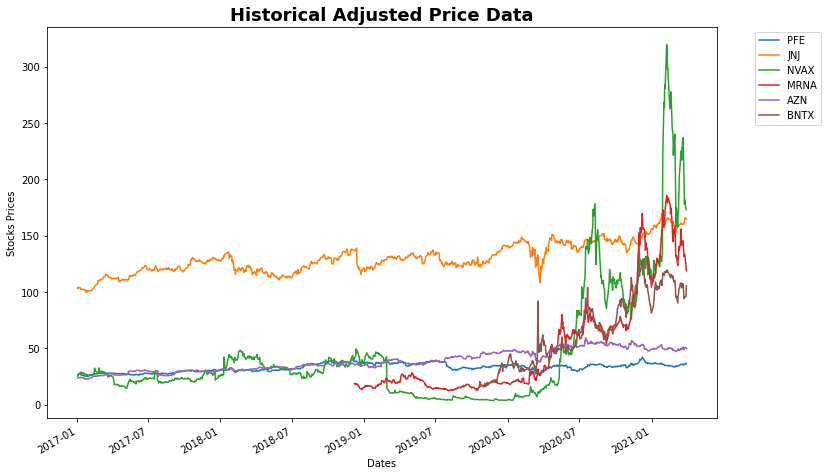

In [3]:
multi_stock_data = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=True, stock_value='Adj Close')
multi_stock_data

In [4]:
multi_stock_data.to_csv('multi_pharm_data')

In [5]:
#start='2017',end='today'
multi_stocks = pd.read_csv('multi_pharm_data', parse_dates=True, index_col='Date')

#### Multiple Stock Plot

In [6]:
def multi_plot(df, stock_value=None):
    #plt.figure(figsize=(12,8))
    df.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font)            

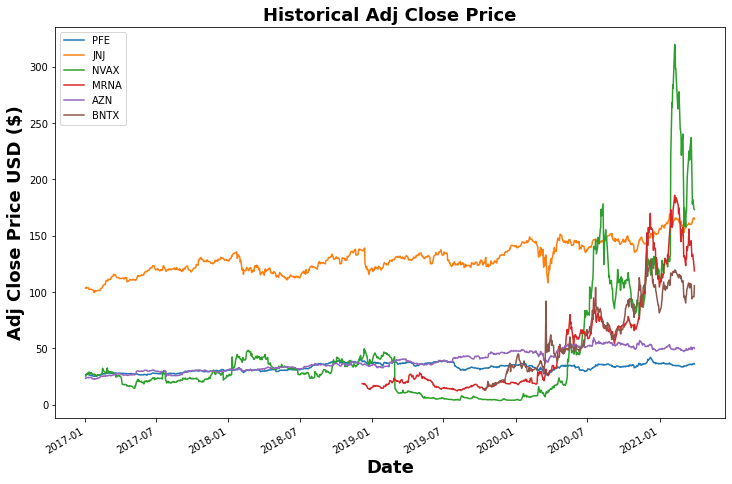

In [7]:
multi_plot(multi_stocks, stock_value='Adj Close')

In [8]:
multi_stocks.describe()

PFE          JNJ         NVAX        MRNA          AZN  \
count  1067.000000  1067.000000  1067.000000  581.000000  1067.000000   
mean     32.903128   129.991146    44.306232   50.518752    38.689568   
std       3.677552    13.746119    52.334749   44.900634     9.168655   
min      25.159119    99.793396     3.690000   12.260000    22.596422   
25%      30.073886   120.284298    12.785000   17.900000    30.854332   
50%      33.258137   128.294250    27.200001   24.430000    36.463421   
75%      36.084934   139.974907    42.799999   69.870003    47.377226   
max      42.101986   169.423508   319.929993  185.979996    59.466022   

             BNTX  
count  370.000000  
mean    65.083340  
std     31.687619  
min     12.750000  
25%     36.752501  
50%     62.225000  
75%     92.000000  
max    129.539993

### Single Stock Data (pfe_stock_data)

In [9]:
def single_stock_data(symbol, start,end=None,plot=True,stock_value='Adj Close'):
    
    try:
        
        df = web.DataReader(symbol,'yahoo', start, end)
        df_single = pd.DataFrame(df)
        print("Dataframe has {} rows and {} columns".format(df_single.shape[0],df_single.shape[1]))
        print()
        if plot==True:
            plt.figure(figsize=(12,8))
            plt.plot(df_single[stock_value])
            label_font = {'weight':'bold','size':18}
            plt.xlabel('Date',fontdict=label_font)
            plt.ylabel('Close Price USD ($)',fontdict=label_font)
            plt.title(f'Historical {stock_value} Price for {symbol}',fontdict=label_font)
            #plot = go.Scatter(x=df_single.index, y=df_single['Adj Close'])
            
        return df_single
        
    except Exception as e:
        #if inccorect symbol is inputted, error message displayed
        print("Error occured/Incorrect Symbol:", e)
        #data = 'Incorrect Symbol'


This is data for Pfizer.

Dataframe has 1067 rows and 6 columns



High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2017-01-03  31.309298  30.920303  31.024668  31.309298  23391844.0  26.653324
2017-01-04  31.641365  31.337761  31.432638  31.584440  22753963.0  26.887548
2017-01-05  31.963947  31.423149  31.660341  31.888046  21083584.0  27.146002
2017-01-06  31.973434  31.631880  31.935484  31.764706  18418228.0  27.041008
2017-01-09  31.944971  31.669828  31.717268  31.755219  21559886.0  27.032928
...               ...        ...        ...        ...         ...        ...
2021-03-24  35.930000  35.369999  35.480000  35.610001  22883400.0  35.610001
2021-03-25  35.790001  35.250000  35.650002  35.669998  24875300.0  35.669998
2021-03-26  36.290001  35.639999  35.680000  36.250000  27897100.0  36.250000
2021-03-29  36.740002  35.900002  36.029999  36.619999  26996000.0  36.619999
2021-03-30  36.630001  36.049999  36.590000  36.145000  12430829.0  36.145000

[1067 rows x 6 columns]

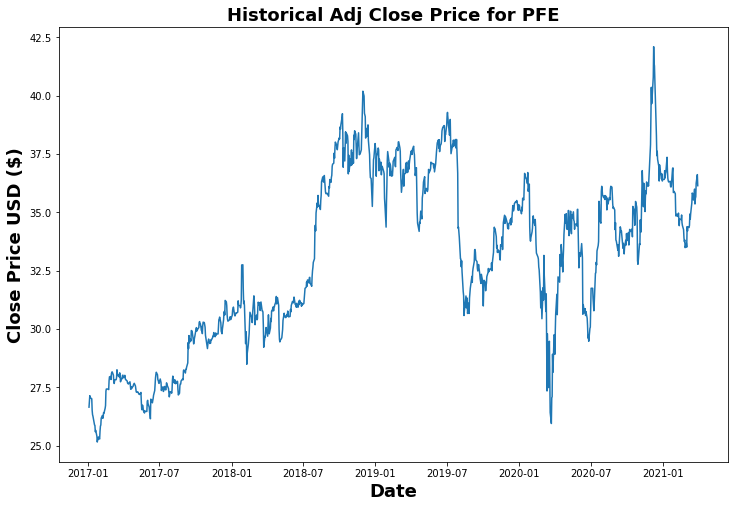

In [10]:
start='01-01-2017'
end='today'
pfe_stock = single_stock_data('PFE', start= start,end='today',plot=True,stock_value='Adj Close')
pfe_stock

In [11]:
pfe_stock.to_csv('pfe_stock')
pfe_stock_df = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')
#single_stock['Close']['2015-04-01':'2015-12-01'].plot()
pfe_stock_data = pfe_stock_df[['Close','Volume','Adj Close']]

In [12]:
pfe_stock_data.describe()

Close        Volume    Adj Close
count  1067.000000  1.067000e+03  1067.000000
mean     35.580776  2.605451e+07    32.903123
std       3.283471  1.367816e+07     3.677548
min      27.030361  5.187683e+06    25.159119
25%      33.462997  1.814688e+07    30.073886
50%      34.867172  2.283343e+07    33.258137
75%      37.649298  2.950821e+07    36.084934
max      43.861481  2.301539e+08    42.101986

#### Single Stock Plot

In [13]:
def single_plot(df,stock_value=None, stock_symbol=None):
    df[stock_value].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'{stock_symbol} {stock_value} History',fontdict=label_font)                

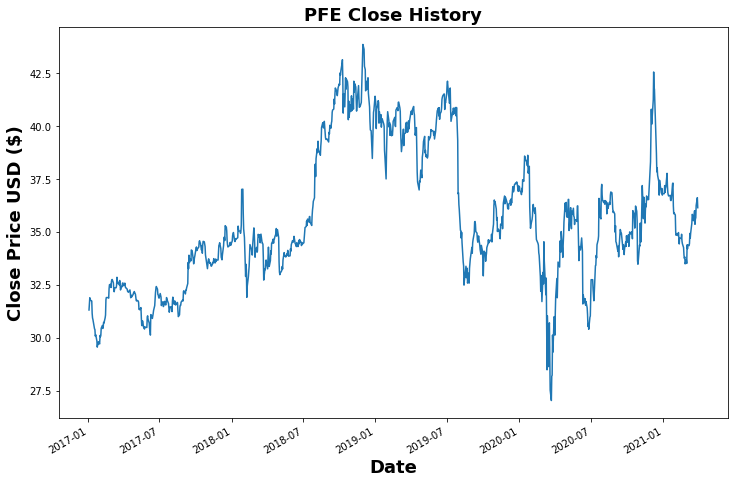

In [14]:
single_plot(pfe_stock_data, stock_value='Close', stock_symbol='PFE')

In [15]:
pfe_stock_data['Adj Close'].describe()

count    1067.000000
mean       32.903123
std         3.677548
min        25.159119
25%        30.073886
50%        33.258137
75%        36.084934
max        42.101986
Name: Adj Close, dtype: float64

## Technical Indicators
The practice of analyzing and executing stock trades is becoming increasingly automated with algorithimic trading.  The usage of technnical indicators is part of algorithmic trading. What are technical indicators and how are they used by Technical Analyst in stock trading?  Technical indicators are methods or pattern-based signals produced by the price, volume, and/or open interest of a stock which are used by traders who follow technical analysis.  Technical analysts believe past trading activity and price changes of a security can be valuable indicators of the security's future price movements. https://www.investopedia.com/terms/t/technicalindicator.asp<br>Technical analysts look for indicators in the historical data and use them to predict future price movements.  The analysts also use them to look for entry and exit points in markets to conduct trades.  I will discuss the below popular technical indicators which are used in the markets to study price movements:

1. Moving Averages (MA)
    > Simple Moving Average<br>
    > Exponential Moving Average<br>
2. Rate of Change (ROC)
3. Relative Strength Index (RSI)

### Moving Averages
The moving average is also known as the rolling mean or running average.  Moving averages smooth out the curve by filtering out the noise inorder to highlight components in the data such as trends and seasonality.  The moving average smooths out the variations in the dataset by calculating the moving average.  Two common types of moving averages are Simple Moving Average (SMA), and Exponential Moving Average (EMA). <br>

#### Simple Moving Average
The Simple Moving Average is the arithmetic mean of all the stock prices or the sum of all the stock prices divided by the number of periods.  We can use the Python rolling method to calculate moving averages.  SMA calculates the average of prices over a given interval of time and is used to determine the trend of the stock. Common time periods used for moving averages are 5, 10, 20, 50, 200 days.  A 10 time period SMA would mean 10 trading days.  In this case I am  considering the past 10 and 50 days and averaging each group, so there won't be any results for these begining entries.<br>  
The below graph pertains to Pfizer stock and looks like the stock price is volatile with lots of fluctuations and noise.  The plot shows the Adj Close price and 10 and 50-day moving averages.  The 10-day follows the Close price pretty closely but smooths out the positve and negative spikes in prices.  The 50-day eliminates most of the volatility.  The SMA smooths out the noise and gives a more accurate picture of how stock performs during volatile periods.<br><br><br>
I would like to highlight certain time periods that highllight how this stock has performed during volatile periods.  Aound 2/18, there was a spike in price from \\$35.00 to almost \\$37.50 and then dropped quickly to almost \\$32.00.  What is the SMA showing us?  SMA gives a more realistic picture of what happened with stock the price. The price increased and dropped precipitously.  We may not know what precipitated such activity, but what were the 10 and 50 day averages around this time period for a more accurate picture of what the stock price was for that period?  How does this compare to performance of the stock in general?  What's interesting is that if we do subsets of for time period of 2/18 to for 10 and 50 averages we can get closer look at what the averge price was.  The average price of the stock was \\$35.578751.  When applying 10 and 50-day the average price is still \\$35.  When I subset the data the average price was \\$34.015994.  When I applied the 10 and 50-day Moving Averages the average price is still a \\$34.052809 and \\$34.168457, respectively.  So is the stock price really that volatile? Not really. <br><br>
Around 8/2019, the price was pretty volatile.  

##### Moving Average Convergence/Divergence Cross Over Stategy
The MACD can be used for for various MAs.  Stock market analysts and investors use the Exponential Moving Average Crossover strategy to analyze price trends and predict upcoming change in trends.  A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset. When the short term moving average crosses above the long term moving average, this indicates a buy signal. However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.  The 50-day moving average is the one that takes longer to adjust to sudden price changes, while the 10-day one is much faster to account for sudden changes.  In the code below I am defining buying and selling signals for the crossover strategy.
The logic of the strategy is as follows:
when the fast MA crosses the slow one upwards, we buy the asset.  When the slow MA crosses the fast one upwards, we sell the asset.
<br>
<br>
For example, around 5/18 there is a signal to puchase.  Around this time the stock was selling for around \\$34.00 per share.  If we had puchased it we could've sold shares around 10/8 for \\$42.00 per share and made a nice profit.  The MACD shows us where the previous trends were with price and potential for making and losing money.  The MACD shows that there is price volatility if looking for short-term investments.  Around 8/18 the price was around \\$41.00. The signal indicats to sell because there is an upcoming signicant drop in price around 9/18 to \\$32.50    

In [16]:
sma_func_calc = pd.read_csv('pfe_stock', parse_dates=True, index_col='Date')

In [17]:
def sma_function(data, col1=None, col2=None, col3=None, symbol=None):
    data[col2] = data[col1].rolling(10).mean()
    data[col3] = data[col1].rolling(50).mean()

    data['Signal'] = 0.0
    data['Signal'] = np.where(data[col2] > data[col3], 1.0, 0.0)
    data['Position'] = data['Signal'].diff()

    data = data.dropna()
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = '10-day SMA') 
    data[col3].plot(color = 'green', label = '50-day SMA')
    label_font = {'weight':'bold','size':18}
    plt.title(f'{symbol} Smooth Moving Average',fontdict=label_font)
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data[col1].plot(color = 'blue', label= 'Close Price',alpha=0.5) 
    data[col2].plot(color = 'red',label = col2) 
    data[col3].plot(color = 'green', label = col3)
    # plot ‘buy’ signals
    plt.plot(data[data['Position'] == 1].index, 
             data[col2][data['Position'] == 1], 
             '^', markersize = 10, color = 'green', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data[col2][data['Position'] == -1], 
             'v', markersize = 10, color = 'red', label = 'sell')
    
    plt.ylabel('Stock Price', fontsize = 15,fontdict=label_font)
    plt.xlabel('Date',fontdict=label_font)
    plt.title(f'{symbol} SMA Crossover Stategy',fontdict=label_font)
    plt.legend(loc='best',fontsize=14)
    plt.grid()
    plt.show()
        
    return data

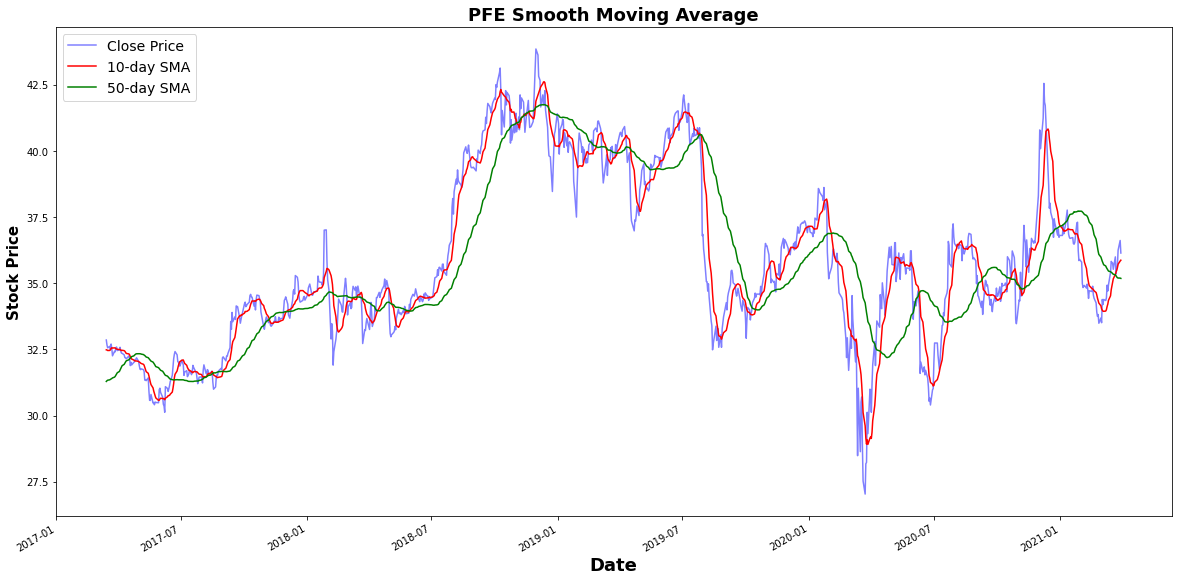

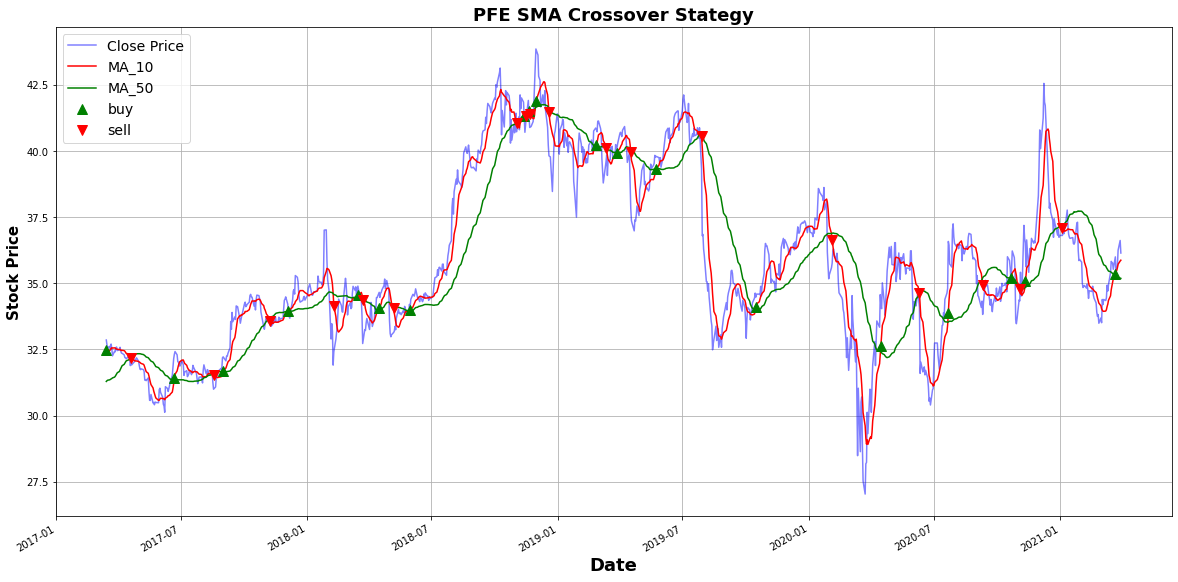

High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2017-03-15  32.922199  32.428844  32.466793  32.855785  24279839.0  28.254789   
2017-03-16  32.855785  32.495255  32.798862  32.666035  21816219.0  28.091606   
2017-03-17  32.808350  32.514233  32.694496  32.561668  45736117.0  28.001856   
2017-03-20  32.732449  32.561668  32.637569  32.618595  18435514.0  28.050808   
2017-03-21  32.836811  32.428844  32.713470  32.495255  33083479.0  27.944742   
...               ...        ...        ...        ...         ...        ...   
2021-03-24  35.930000  35.369999  35.480000  35.610001  22883400.0  35.610001   
2021-03-25  35.790001  35.250000  35.650002  35.669998  24875300.0  35.669998   
2021-03-26  36.290001  35.639999  35.680000  36.250000  27897100.0  36.250000   
2021-03-29  36.740002  35.900002  36.029999  36.619999  26996000.0  36.619999   
2021-03-30  36.630001  36.049999  36.590000  36.145000  12430829.0  36.145000   

                MA_10      MA_50  Signal  Position  
Date                                                
2017-03-15  32.485769  31.289754     1.0       1.0  
2017-03-16  32.478179  31.316888     1.0       0.0  
2017-03-17  32.459203  31.336433     1.0       0.0  
2017-03-20  32.462049  31.351044     1.0       0.0  
2017-03-21  32.486717  31.365655     1.0       0.0  
...               ...        ...     ...       ...  
2021-03-24  35.495000  35.242600     1.0       0.0  
2021-03-25  35.591000  35.212400     1.0       0.0  
2021-03-26  35.722000  35.200200     1.0       0.0  
2021-03-29  35.843000  35.197600     1.0       0.0  
2021-03-30  35.874500  35.186500     1.0       0.0  

[1018 rows x 10 columns]

In [18]:
sma_data = sma_function(sma_func_calc,col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_data

In [19]:
sma_data[['Close','MA_10','MA_50']].describe()

Close        MA_10        MA_50
count  1018.000000  1018.000000  1018.000000
mean     35.788856    35.772843    35.705055
std       3.210622     3.154089     2.959013
min      27.030361    28.910816    31.284440
25%      33.683410    33.753795    33.918359
50%      34.971539    34.919473    34.852372
75%      38.256643    38.236477    37.669209
max      43.861481    42.622391    41.757495

#### SMA Subset

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

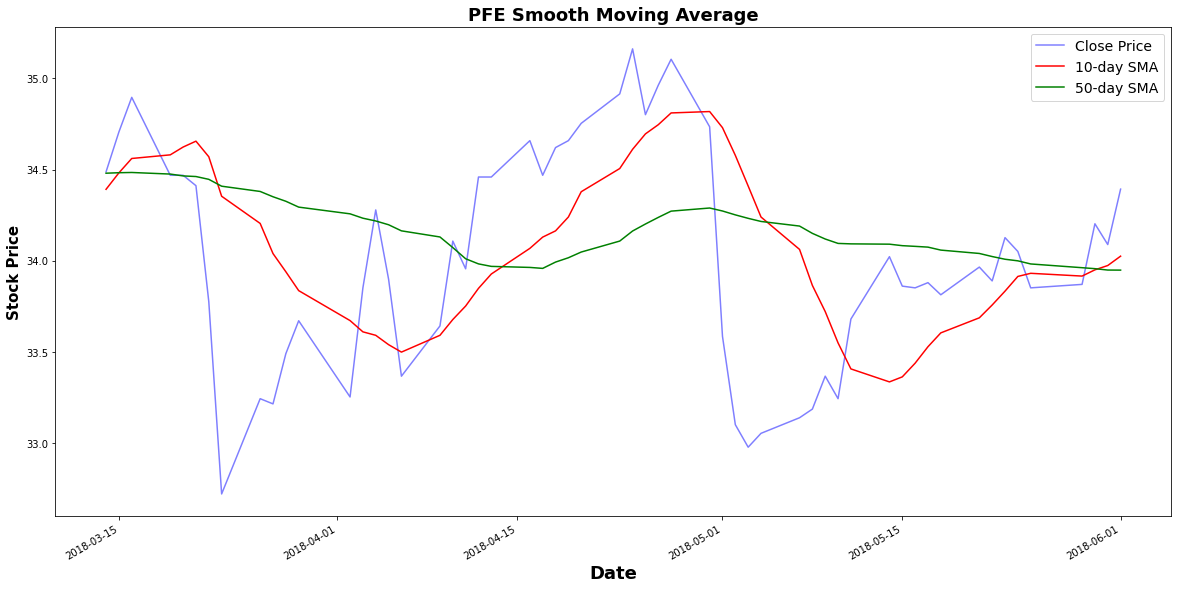

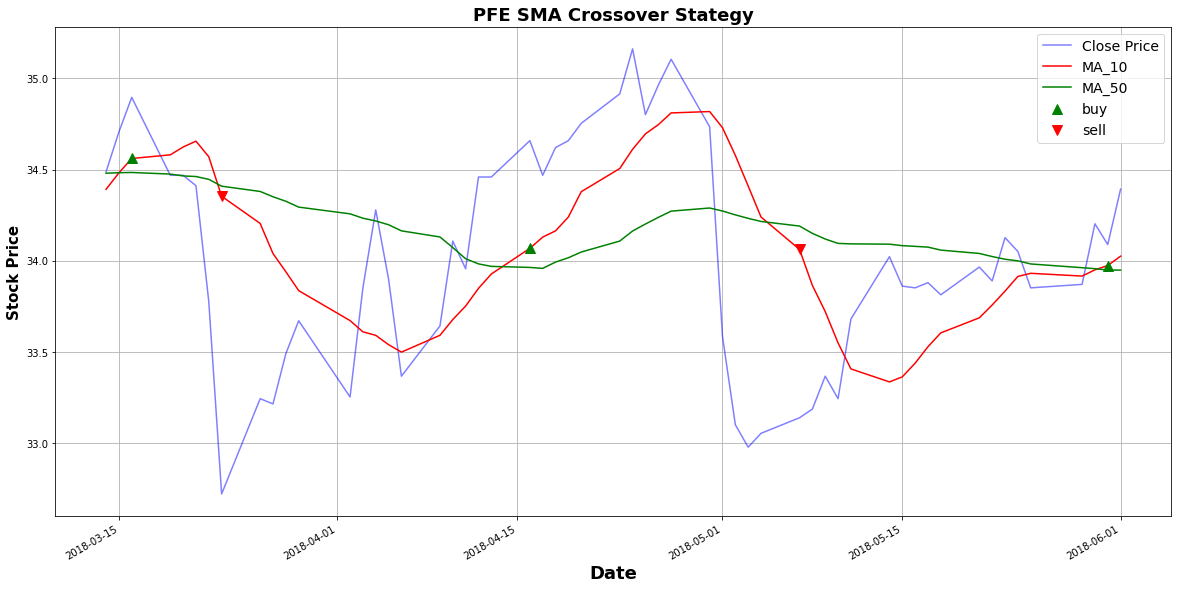

In [20]:
sma_rolling_3 = sma_function(sma_func_calc['2018-01-01':'2018-06-01'],col1='Close',col2='MA_10',col3='MA_50',symbol='PFE')
sma_rolling_3;

In [21]:
print('Close Price')
print(sma_rolling_3['Close'].describe())
print()
print('10 Day Moving Average')
print(sma_rolling_3['MA_10'].describe())
print()
print('50 Day Moving Average')
print(sma_rolling_3['MA_50'].describe())

Close Price
count    56.000000
mean     34.015994
std       0.607358
min      32.722961
25%      33.629033
50%      33.961100
75%      34.468693
max      35.161289
Name: Close, dtype: float64

10 Day Moving Average
count    56.000000
mean     34.052809
std       0.430600
min      33.336811
25%      33.685484
50%      33.962524
75%      34.427893
max      34.817837
Name: MA_10, dtype: float64

50 Day Moving Average
count    56.000000
mean     34.168457
std       0.166282
min      33.949146
25%      34.021869
50%      34.140607
75%      34.272486
max      34.484061
Name: MA_50, dtype: float64


#### Exponential Moving Average (EMA)
 The EMA is also referred to as the exponentially weighted moving average.  The difference between EMA and SMA is that SMA assigns equal weight to all periods.  Whereas, with EMA the latest prices are given higher weights and it assigns lesser weight to past data.  EMA is used more by short term traders because it is quicker to react to price changes compared to SMA which is slower. This technical indicator is used to produce buy and sell signals based on crossovers and divergences from the historical price average.  https://www.investopedia.com/terms/e/ema.asp
 <br>

#### MACD Crossover
Short term moving average usually last 12 periods and long term last 26 periods.  The Signal line is generally a 9 period exponentially smooth average of the MACD line.  This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average.  This program uses the MACD Crossover to determine when to buy and sell stocks.<br>
A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes.  Whereas, a long-term moving average is deemed slower as it encapsulates prices over a longer period and a slower response to daily prices.<br>
The MACD line is calculated by taking the short term exponenrial moving average minus the long term exponetial moving average.  When the red line crosses above the green line you see an increase in the price and every time the red drops below the EMA26 you see the price decrease.<br>When MACD line crosses above the signal line that indicates a good time to buy and when it is below signal line that indcates a time to sell.

In [22]:
macd_df_1 = pfe_stock_data.copy()

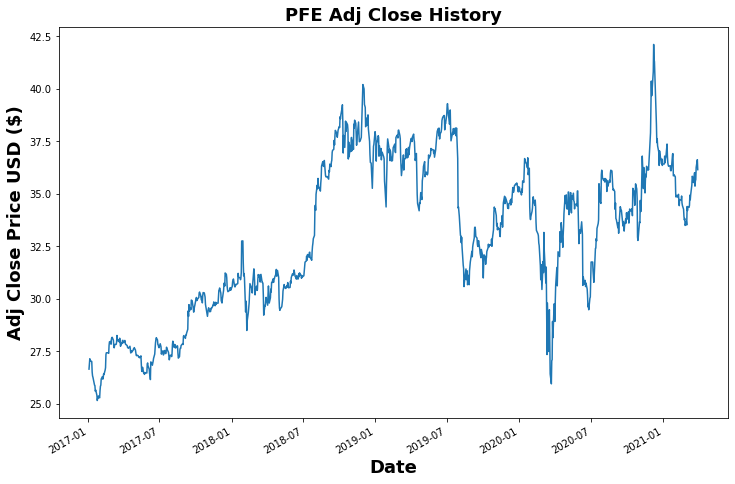

In [23]:
#ema_function(macd_df)
single_plot(macd_df_1, stock_value='Adj Close', stock_symbol='PFE')

#### Exponential Moving Average Crossover Stratergy
Stock market analysts and investors use Exponential Moving Average Crossover strategy, among other moving averages, to analyze price trends and predict upcoming change of trends.  A moving-average crossover occurs when plotting, the two moving averages each based on different time-periods tend to cross. This indicator uses two (or more) moving averages — a faster moving average (short-term) and a slower (long-term) moving average. The faster moving average may be 5-, 10- or 25-day period while the slower moving average can be 50-, 100- or 200-day period.  A short term moving average is faster because it only considers prices over short period of time and is thus more reactive to daily price changes. On the other hand, a long-term moving average is deemed slower as it encapsulates prices over a longer period and is more lethargic.<br>
A crossover occurs when a faster moving average (i.e. a shorter period moving average) crosses a slower moving average (i.e. a longer period moving average). In stock trading, this meeting point can be used as a potential indicator to buy or sell an asset.
When the short term moving average crosses above the long term moving average, this indicates a buy signal.
However, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.<br>

In [24]:
ewmal_2 = pfe_stock_data.copy() 

In [25]:
def ema_function(data, span1=None,span2=None):    
    # Create 20 days exponential moving average column
    data['12_EMA'] = data['Close'].ewm(span = span1, adjust = False).mean()
    # Create 50 days exponential moving average column
    data['26_EMA'] = data['Close'].ewm(span = span2, adjust = False).mean()

    #create a new column 'Signal' such that if 20-day EMA is greater   # than 50-day EMA then set Signal as 1 else 0
    data['Signal'] = 0.0  
    data['Signal'] = np.where(data['12_EMA'] > data['26_EMA'], 1.0, 0.0)

    # create a new column 'Position' which is a day-to-day difference of # the 'Signal' column
    data['Position'] = data['Signal'].diff()

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')

    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    data['Close'].plot(color = 'b', label= 'Close Price') 
    data['12_EMA'].plot(color = 'r',label = '12-day EMA') 
    data['26_EMA'].plot(color = 'g', label = '26-day EMA')
    # plot ‘buy’ signals
    plt.plot(data[ewmal_2['Position'] == 1].index, 
             data['12_EMA'][ewmal_2['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(data[data['Position'] == -1].index, 
             data['12_EMA'][data['Position'] == -1], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('Stock Price', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Pfizer EWMA Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    
    return data

Close      Volume  Adj Close     12_EMA     26_EMA  Signal  \
Date                                                                         
2017-01-03  31.309298  23391844.0  26.653324  31.309298  31.309298     0.0   
2017-01-04  31.584440  22753963.0  26.887548  31.351627  31.329679     1.0   
2017-01-05  31.888046  21083584.0  27.146002  31.434153  31.371039     1.0   
2017-01-06  31.764706  18418228.0  27.041008  31.485007  31.400200     1.0   
2017-01-09  31.755219  21559886.0  27.032928  31.526578  31.426497     1.0   
...               ...         ...        ...        ...        ...     ...   
2021-03-24  35.610001  22883400.0  35.610001  35.344814  35.133422     1.0   
2021-03-25  35.669998  24875300.0  35.669998  35.394843  35.173169     1.0   
2021-03-26  36.250000  27897100.0  36.250000  35.526405  35.252934     1.0   
2021-03-29  36.619999  26996000.0  36.619999  35.694650  35.354198     1.0   
2021-03-30  36.145000  12430829.0  36.145000  35.763935  35.412776     1.0   

            Position  
Date                  
2017-01-03       NaN  
2017-01-04       1.0  
2017-01-05       0.0  
2017-01-06       0.0  
2017-01-09       0.0  
...              ...  
2021-03-24       0.0  
2021-03-25       0.0  
2021-03-26       0.0  
2021-03-29       0.0  
2021-03-30       0.0  

[1067 rows x 7 columns]

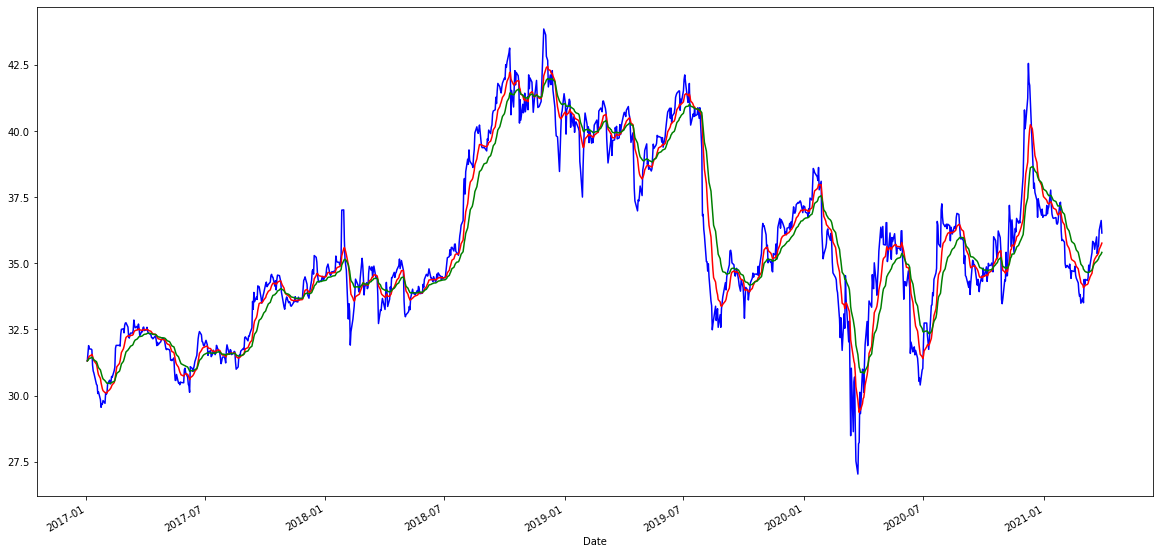

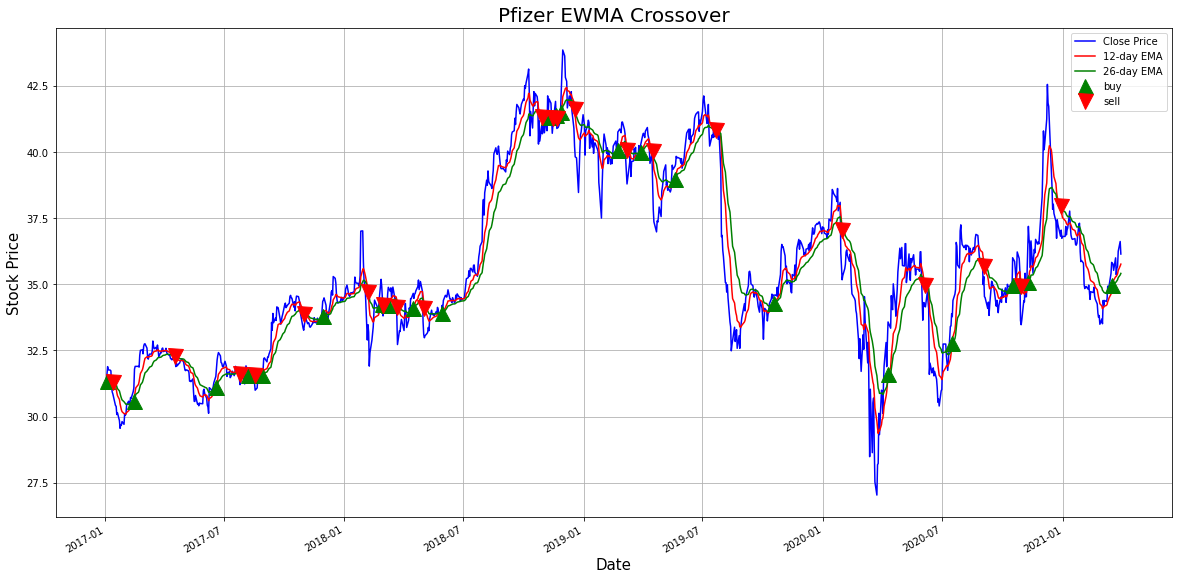

In [26]:
ewm_calc = ema_function(ewmal_2,span1 = 12,span2 = 26)
ewm_calc

In [27]:
#ewm_calc.head()

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



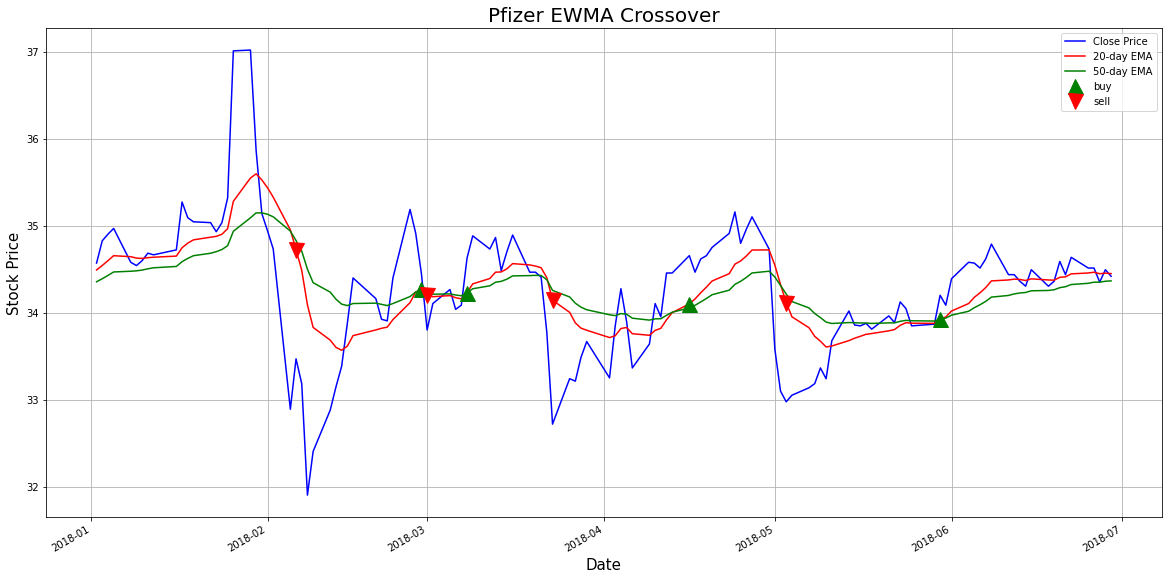

In [28]:
ewmal_3 = ewmal_2['2018-01-01':'2018-07-01']
plt.figure(figsize = (20,10))
# plot close price, short-term and long-term moving averages 
ewmal_3['Close'].plot(color = 'b', label= 'Close Price') 
ewmal_3['12_EMA'].plot(color = 'r',label = '20-day EMA') 
ewmal_3['26_EMA'].plot(color = 'g', label = '50-day EMA')
# plot ‘buy’ signals
plt.plot(ewmal_3[ewmal_2['Position'] == 1].index, 
         ewmal_3['12_EMA'][ewmal_2['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot ‘sell’ signals
plt.plot(ewmal_3[ewmal_3['Position'] == -1].index, 
         ewmal_3['12_EMA'][ewmal_3['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('Pfizer EWMA Crossover', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Rate of Change
The Rate of Change (ROC) is a technical indicator that measures the percentage change between the most recent price and the price a specified number of days before. The indicator fluctuates around the zero line.
#### Historical Price Change Analysis
Volatility is the range of price changes a security experiences over a given period of time. If the price stays relatively stable, the security has low volatility. A highly volatile security hits new highs and lows quickly, moves erratically, and has rapid increases and dramatic falls.  Is volatility in price good or bad for trading? This is a complex question with multiple possible answer.  One possible answer is that as the price fluctuates, it provides the opportunity for investors to buy stock in a solid company when the price is very low, and then wait for cumulative growth down the road.  https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp<br>
For short-term traders, volatility is even more crucial. Day traders work with changes that occur second-to-second, minute-to-minute. If there is no price change, there is no profit.https://www.investopedia.com/ask/answers/010915/volatility-good-thing-or-bad-thing-investors-point-view-and-why.asp The graph shows that the data points are now centered aound 0. The graph shows that around 3/20 was a volatile period for the stock price and it increase above 7% and decreased 7%.



### Price Change in Dollars
To see how big the changes in price were on a daily basis we subtract yesterday's closing price yesterday from today.  This will show the change in price.  A column named 'Actual_Changes' is added to calculate actual change in dollars.<br>For example, we can see that on 1/3/17 the Adj Closing price was 26.653324 and on 1/4/17 the Adj Closing price was 26.887548.  The price change $0.234224.<br> 

Scatterplot of absolute value of magnitude change vs. actual change. Let's us see how the price changes daily.<br>

In [29]:
# sdr = multiple_stock_data(ticker=[['PFE','JNJ','NVAX','MRNA','AZN','BNTX']], start='2017',end='today',plot=False, stock_value='Adj Close')
# sdr
price_change = pfe_stock_data.copy()

In [30]:
#leavr off 1 b/c that's default value
#using shift function
#26.887548 - 26.653324 = 0.234224
def price_change_func(data, col1=None,stock_value=None):
    data['Actual_Changes'] = data[col1] - data[col1].shift(1)
    # price_change['Expected_Changes'] =price_change['Close'] * #std deviation or 21 day 

    data['Actual_Changes'].plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel(f'{stock_value} Price USD ($)',fontdict=label_font)
    plt.title(f'Historical {stock_value} Price',fontdict=label_font) 
    
    return data

Close      Volume  Adj Close  Actual_Changes
Date                                                        
2017-01-03  31.309298  23391844.0  26.653324             NaN
2017-01-04  31.584440  22753963.0  26.887548        0.234224
2017-01-05  31.888046  21083584.0  27.146002        0.258453
2017-01-06  31.764706  18418228.0  27.041008       -0.104994
2017-01-09  31.755219  21559886.0  27.032928       -0.008080
...               ...         ...        ...             ...
2021-03-24  35.610001  22883400.0  35.610001        0.250000
2021-03-25  35.669998  24875300.0  35.669998        0.059998
2021-03-26  36.250000  27897100.0  36.250000        0.580002
2021-03-29  36.619999  26996000.0  36.619999        0.369999
2021-03-30  36.145000  12430829.0  36.145000       -0.474998

[1067 rows x 4 columns]

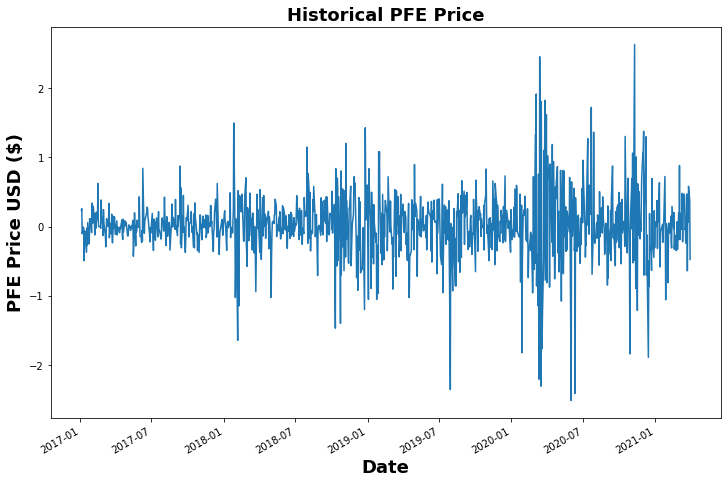

In [31]:
#price_change,
price_change_data = price_change_func(price_change,col1='Adj Close',stock_value='PFE')
price_change_data

The below graph shows that for the stated time the stock price difference was rarely positively more than $2.627 than negatviely more than -2.511.  The average daily return was 0.007375.<br>

In [32]:
#the mean (average) change was less than 1 cent
#absolute
price_change_1 = price_change.copy()
price_change_1['Actual_Changes'] = price_change_1['Actual_Changes'].abs() 
price_change_1['Actual_Changes'].describe()

count    1066.000000
mean        0.315152
std         0.355997
min         0.000000
25%         0.090616
50%         0.203945
75%         0.414892
max         2.627960
Name: Actual_Changes, dtype: float64

In [33]:
#single_plot(price_change, stock_value='Actual_Changes',stock_symbol='PFE')

In [34]:
#multi_stocks

In [35]:
multi_price_change = multi_stocks.copy()

MRNA, AZNA, JNJ didn't have a big daily price differece either psotively or negatively. NVAX did have spikes in daily price 
both psotively and negatively. NVAX average stock price is \\$41.94.  Around 2/21, the price spiked to 319.929 and 3.690000.  The price had increased \\$86.930 but then decreased \\$-34.299.<br>

In [36]:
def multi_price_change_func(data):
    data = data - data.shift(1)
    data.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return data

PFE       JNJ       NVAX      MRNA       AZN      BNTX
Date                                                                   
2017-01-03       NaN       NaN        NaN       NaN       NaN       NaN
2017-01-04  0.234224 -0.169662   0.800001       NaN  0.186050       NaN
2017-01-05  0.258453  1.080444   0.199999       NaN  0.642715       NaN
2017-01-06 -0.104994 -0.500038   1.000000       NaN -0.219879       NaN
2017-01-09 -0.008080 -0.017860   1.000000       NaN  0.084570       NaN
...              ...       ...        ...       ...       ...       ...
2021-03-24  0.250000  1.559998 -19.599991 -4.910004 -0.610001 -6.059998
2021-03-25  0.059998  0.059998 -22.010010  1.720001  0.910000  1.079994
2021-03-26  0.580002  2.959991   3.889999 -0.050003  0.939999  0.630005
2021-03-29  0.369999  1.110001  -8.369995 -9.860001  0.170002  0.150002
2021-03-30 -0.469997 -1.169998  -0.539993 -4.599998 -0.870003  9.675995

[1067 rows x 6 columns]

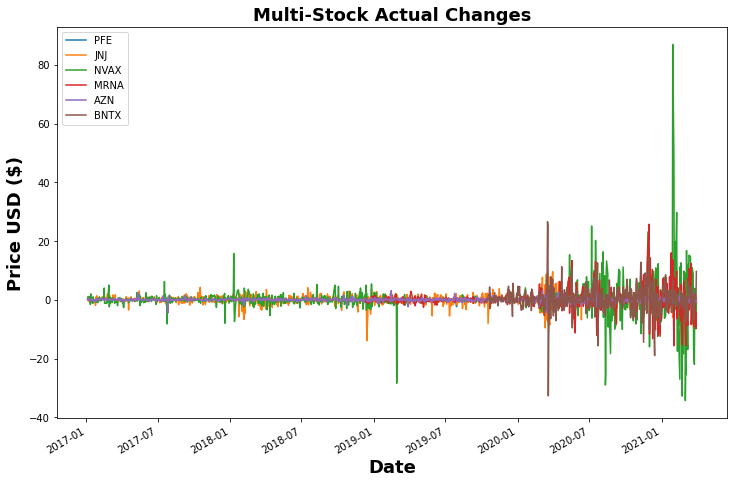

In [37]:
multi_price_calc = multi_price_change_func(multi_price_change)
multi_price_calc

In [38]:
multi_price_calc.describe()

PFE          JNJ         NVAX        MRNA          AZN  \
count  1066.000000  1066.000000  1066.000000  580.000000  1066.000000   
mean      0.008909     0.057630     0.138659    0.172793     0.024865   
std       0.475461     1.723509     5.413214    3.709696     0.684101   
min      -2.511635   -13.964050   -34.299988  -15.680008    -4.421049   
25%      -0.179914    -0.566261    -0.600000   -0.727501    -0.247996   
50%       0.008669     0.082512     0.000000    0.020000     0.028324   
75%       0.218035     0.812868     0.799999    1.029999     0.304561   
max       2.627960     9.590652    86.930008   25.710007     3.912495   

             BNTX  
count  369.000000  
mean     0.247550  
std      4.650936  
min    -32.700001  
25%     -1.839996  
50%      0.130001  
75%      2.329998  
max     26.599998

In [39]:
def hist_func_actual(data, col=None):
    plt.figure(figsize=(12,8))
    data[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Actual Change')
    plt.ylabel('Frequency')

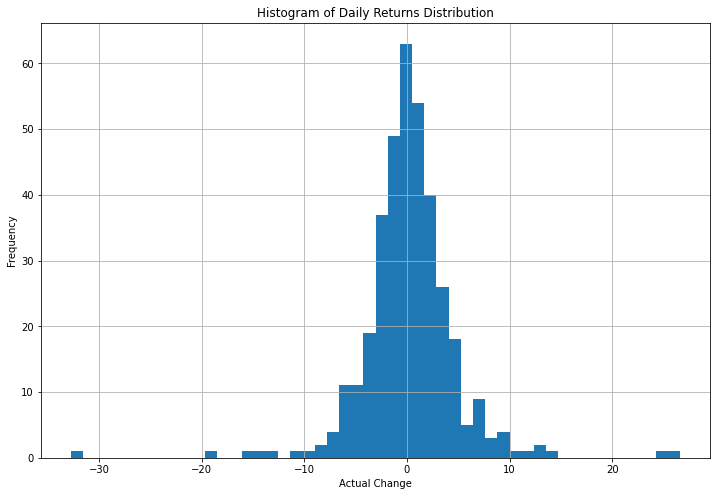

In [40]:
hist_func_actual(multi_price_calc, col='BNTX')

### Simple Daily Return
Daily price change as a percentage

In [41]:
multi_stocks.head()

PFE         JNJ       NVAX  MRNA        AZN  BNTX
Date                                                               
2017-01-03  26.653324  103.436539  25.400000   NaN  23.433638   NaN
2017-01-04  26.887548  103.266876  26.200001   NaN  23.619688   NaN
2017-01-05  27.146002  104.347321  26.400000   NaN  24.262403   NaN
2017-01-06  27.041008  103.847282  27.400000   NaN  24.042524   NaN
2017-01-09  27.032928  103.829422  28.400000   NaN  24.127094   NaN

In [42]:
(26.887548 /26.653324) -1

0.008787796974216056

In [43]:
#new price(cuurent time period) /old price - 1
#26.887548 - 26.653324=
#(26.200001 /25.400000) -1
def multi_price_change_func(data):
    daily_simple_returns = data.pct_change(1) #1 is for 1 day
    daily_simple_returns.plot(figsize=(12,8))
    label_font = {'weight':'bold','size':18}
    plt.xlabel('Date',fontdict=label_font)
    plt.ylabel('Price USD ($)',fontdict=label_font)
    plt.title('Multi-Stock Actual Changes',fontdict=label_font) 
    
    return daily_simple_returns

PFE       JNJ      NVAX      MRNA       AZN      BNTX
Date                                                                  
2017-01-03       NaN       NaN       NaN       NaN       NaN       NaN
2017-01-04  0.008788 -0.001640  0.031496       NaN  0.007939       NaN
2017-01-05  0.009612  0.010463  0.007634       NaN  0.027211       NaN
2017-01-06 -0.003868 -0.004792  0.037879       NaN -0.009063       NaN
2017-01-09 -0.000299 -0.000172  0.036496       NaN  0.003518       NaN
...              ...       ...       ...       ...       ...       ...
2021-03-24  0.007070  0.009729 -0.089156 -0.035965 -0.012348 -0.060533
2021-03-25  0.001685  0.000371 -0.109918  0.013069  0.018651  0.011483
2021-03-26  0.016260  0.018275  0.021826 -0.000375  0.018913  0.006623
2021-03-29  0.010207  0.006730 -0.045959 -0.073980  0.003357  0.001566
2021-03-30 -0.012834 -0.007046 -0.003108 -0.037271 -0.017123  0.100886

[1067 rows x 6 columns]

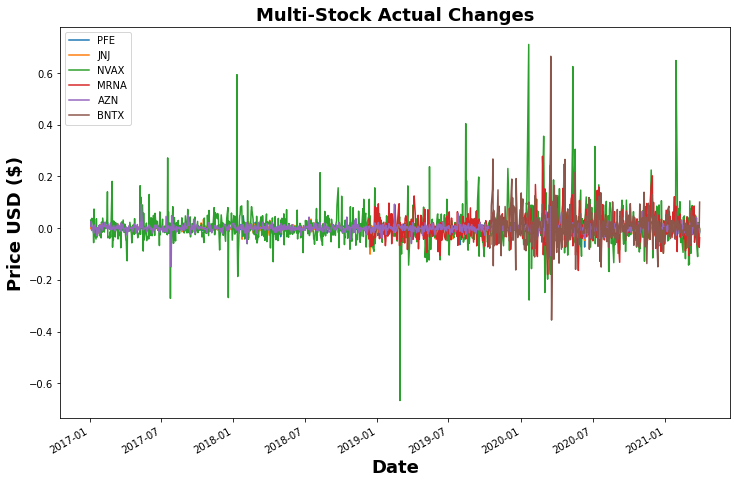

In [44]:
#percent change
#y % change
multi_dsr = multi_price_change_func(multi_stocks)
multi_dsr

In [45]:
#mean of daily simple return
#highest return should be NBTX and lowest for PFE
mean_dsr = multi_dsr.mean()
print('The Daily Mean Simple Return')
mean_dsr

The Daily Mean Simple Return


PFE     0.000390
JNJ     0.000525
NVAX    0.004678
MRNA    0.004533
AZN     0.000847
BNTX    0.008213
dtype: float64

In [46]:
def hist_func(data, col=None):
    plt.figure(figsize=(12,8))
    multi_dsr[col].hist(bins=50)
    plt.title('Histogram of Daily Returns Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')

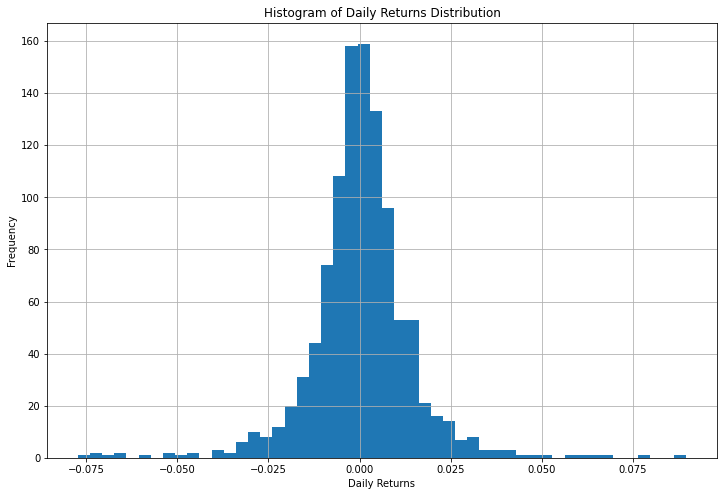

In [47]:
hist_func(multi_dsr, col='PFE')

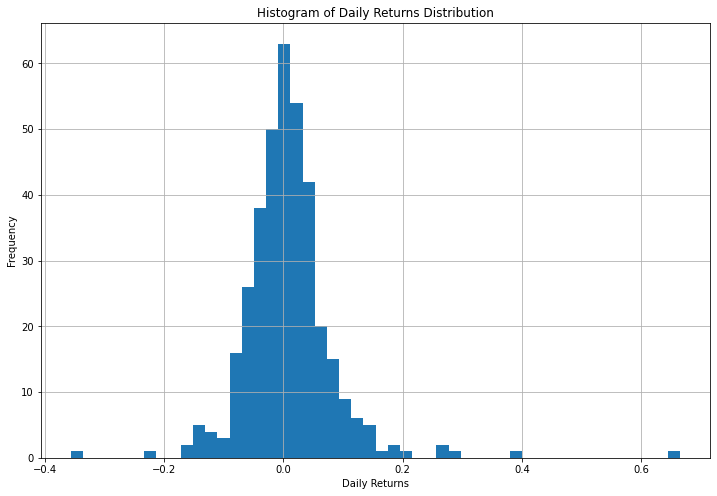

In [48]:
hist_func(multi_dsr, col='BNTX')

In [49]:
36.551258 - 37.603287

-1.0520290000000045

In [50]:
#stock volatility
#print standard deviaiton for daily simple return
#volatility is standard deviation
#Most volatile stock is NVAX, least volatile stock is JNJ
#the higher the volaitility the higher hte return, the lower volatility the lower return
#expect a lower return for JNJ as opposed to BNTX
#no absolute value, only abs when mean
#how different are thwy form each otehr
print('The Stock Volatility')
multi_dsr.std()

The Stock Volatility


PFE     0.014392
JNJ     0.013236
NVAX    0.077046
MRNA    0.052267
AZN     0.016494
BNTX    0.077164
dtype: float64

### Relative Strength Index (RSI)
The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100.  An asset is usually considered overbought when the value is above 70% and oversold when it is below 30%.  
https://www.investopedia.com/terms/r/rsi.asp Overbought refers that the bubble created from the buying might pop soon, and therefore the price will drop. This creates a strong entry point.  interpretation of the RSI is that values of 70 or above indicate that a security is becoming overvalued or overbought and may be due for a trend reversal or correction in price. An RSI value of 30 or below indicates an undervalued or oversold scenario.<br>
<br>
7/19-RSI value dips below 10 indicator, the 10 significant level.
    Tells us stock was oversold and presents a buying opportunity
On Adj Close plot was see that around 7/19 the price dipped from around \\$40.00 to \\$30.00.
    Then the price increased significantly again.
If you followed RSI you wuold have prucahsed around \\$30.00 and prcie jumped to \\$37.5 around 1/20.    

Around 7/18 to 9/18- Looks like stock was being over bought.  RSI value passed 80 level significant indicator.
    price was around \\$38.00 to \\$40.00.
    Pricde did drop to almost $35.00. Would have been a good time to drop prior to the drop.
    Would have saved some money from selling

In [51]:
rsi_df = pfe_stock_data.copy()
rsi_df

Close      Volume  Adj Close
Date                                        
2017-01-03  31.309298  23391844.0  26.653324
2017-01-04  31.584440  22753963.0  26.887548
2017-01-05  31.888046  21083584.0  27.146002
2017-01-06  31.764706  18418228.0  27.041008
2017-01-09  31.755219  21559886.0  27.032928
...               ...         ...        ...
2021-03-24  35.610001  22883400.0  35.610001
2021-03-25  35.669998  24875300.0  35.669998
2021-03-26  36.250000  27897100.0  36.250000
2021-03-29  36.619999  26996000.0  36.619999
2021-03-30  36.145000  12430829.0  36.145000

[1067 rows x 3 columns]

In [52]:
def rsi_function(data, col=None):
    rsi_d = data[col].diff(1)
    rsi_d = rsi_d.dropna()
    #get the postive gains (up) and negative gains(down)
    up = rsi_d.copy()
    down = rsi_d.copy()
    #get the postive values in delta
    up[up < 0]=0  #for any values in up that are less than 0. Any values n up that are less than 0, we'll set to 0
    down[down > 0]=0  #values in down that are greater than 0, they're positive. Set those values equal to 0.
    #up only contins positve values and down only contains negative values
    #Get the time period.  RSI is usually 14 day period
    period=14
    #calculate the average gain and average loss
    AVG_gain = up.rolling(window=period).mean()
    AVG_loss = abs(down.rolling(window=period).mean()) #going to be negative values so use absolute
    #calcualte RSI
    #calcualte relative strength (Rs)
    RS = AVG_gain / AVG_loss
    #calcualte relative strength Index (RSI)
    RSI = 100.0 - (100.0 / (1.0 + RS))
    #new dataframe
    new_df = pd.DataFrame()
    new_df[col] = rsi_df[col]
    new_df['RSI'] = RSI
    
    #plot column
    plt.figure(figsize=(12,8))
    plt.plot(new_df.index, new_df[col])
    plt.title(f'{col} Price History for Pfizer')
    plt.legend(new_df.columns.values, loc='upper left')
    #plot RSI values and signficant levels
    plt.figure(figsize=(12,8))
    plt.title('RSI')
    plt.plot(new_df.index,new_df['RSI'])
    plt.axhline(0, linestyle='--', alpha=0.5,color='gray')
    plt.axhline(10, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(20, linestyle='--', alpha=0.5,color='green')
    plt.axhline(30, linestyle='--', alpha=0.5,color='red')
    plt.axhline(70, linestyle='--', alpha=0.5,color='red')
    plt.axhline(80, linestyle='--', alpha=0.5,color='green')
    plt.axhline(90, linestyle='--', alpha=0.5,color='orange')
    plt.axhline(100, linestyle='--', alpha=0.5,color='gray')
    
    return new_df

Adj Close        RSI
Date                            
2017-01-03  26.653324        NaN
2017-01-04  26.887548        NaN
2017-01-05  27.146002        NaN
2017-01-06  27.041008        NaN
2017-01-09  27.032928        NaN
...               ...        ...
2021-03-24  35.610001  68.503891
2021-03-25  35.669998  67.391250
2021-03-26  36.250000  72.511819
2021-03-29  36.619999  74.164761
2021-03-30  36.145000  63.545139

[1067 rows x 2 columns]

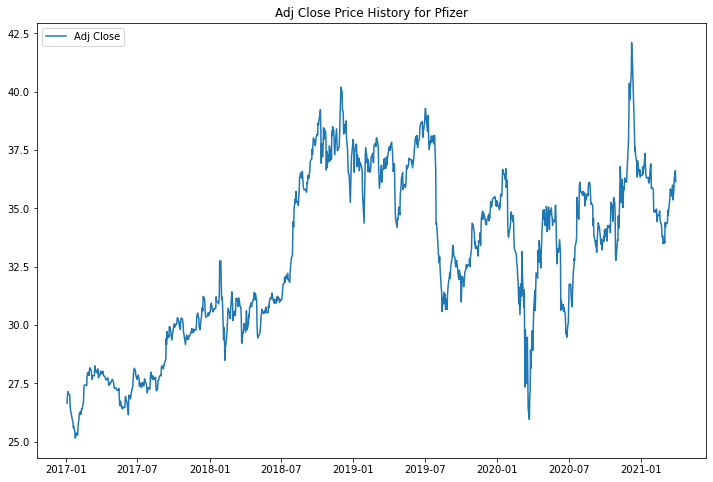

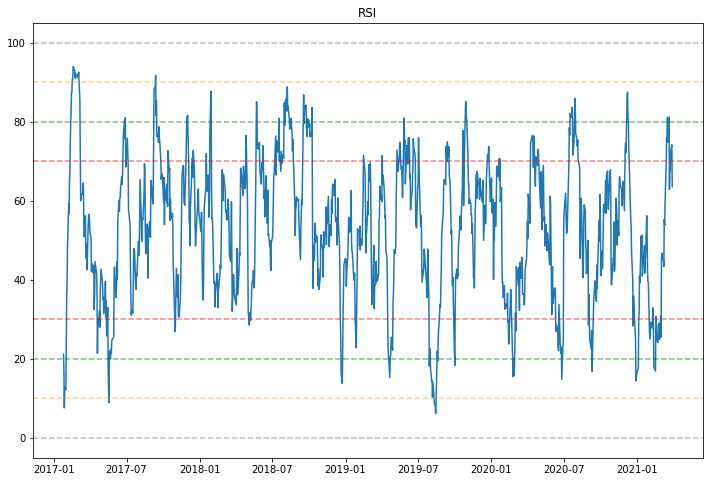

In [53]:
rsi_function(rsi_df, col='Adj Close')

## Question 2: How well do SARIMA algorithms perform with Adj Close column and Techinical Indicators in predictings future stocks prices? 
This section focuses on using SARIMA models to predict future stock prices.  Autoregressive Integrated Moving Average, or ARIMA, is one of the most widely used forecasting methods for univariate time series data forecasting.  Although the method can handle data with a trend, it does not support time series with a seasonal component.Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

In this section I will be working with univariate time series datasets.  I have created various functions which make it easy to just replace the symbol name to get a price prediction for another stock.  I am starting with the Pfizer then I will run the model with BVAX for a comparison.<br>
I created the function delta_data which allows me to add the calculations from Techincal Indicators section to the stock dataset I obtained from Datareader.  I will be working with the columns Adj Close, MA_50 and Actual_Changes.

To make the predicions I will be using One-Step ahead forecasting and Dynamic Forecasting. One Step Ahead static and dynamic forecasts are similar. The difference is with their estimation procedures. Dynamic forecast uses the value of the previous forecasted value of the dependent variable to compute the next one. On the other hand static forecast uses the actual value for each subsequent forecast.

<ins>Adj Close<ins>:<br>
The One Step Forecasting plot shows the confidence intervals 



In [54]:
#start='01-01-2019',end='today',
#df_single = single_stock_data('PFE', start='01-01-2019',end='today',plot=True,stock_value='Adj Close')

## Sarima Model

In [55]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

import statsmodels.api as sm

In [56]:
sarima_data = pfe_stock_data.copy()

#### Delta_data

In [57]:
def delta_data(data,col=None):
    data['Actual_Changes'] = data[col] - data[col].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    
    data = data.dropna()
    return data

In [58]:
sarima_df = delta_data(sarima_data,col='Adj Close')#delta_time_series(multi_stocks, col='Adj Close')

In [59]:
sarima_df

Close      Volume  Adj Close  Actual_Changes  Percent_Chg  \
Date                                                                        
2017-03-15  32.855785  24279839.0  28.254789        0.334522     0.011981   
2017-03-16  32.666035  21816219.0  28.091606       -0.163183    -0.005775   
2017-03-17  32.561668  45736117.0  28.001856       -0.089750    -0.003195   
2017-03-20  32.618595  18435514.0  28.050808        0.048952     0.001748   
2017-03-21  32.495255  33083479.0  27.944742       -0.106066    -0.003781   
...               ...         ...        ...             ...          ...   
2021-03-24  35.610001  22883400.0  35.610001        0.250000     0.007070   
2021-03-25  35.669998  24875300.0  35.669998        0.059998     0.001685   
2021-03-26  36.250000  27897100.0  36.250000        0.580002     0.016260   
2021-03-29  36.619999  26996000.0  36.619999        0.369999     0.010207   
2021-03-30  36.145000  12430829.0  36.145000       -0.474998    -0.012971   

                MA_50  
Date                   
2017-03-15  26.801835  
2017-03-16  26.830601  
2017-03-17  26.852887  
2017-03-20  26.870983  
2017-03-21  26.889058  
...               ...  
2021-03-24  35.155521  
2021-03-25  35.133324  
2021-03-26  35.129057  
2021-03-29  35.134367  
2021-03-30  35.131166  

[1018 rows x 6 columns]

##### Train/Test Split

In [60]:
#training_data_len, dataset, scaler, scaled_data = preprocessing(df_data['Adj Close'], percentage=.8)
# n = int(len(sarima_df) * 0.8)
# train = sarima_df[:n]
# test = sarima_df[n:]

train = sarima_df[:int(0.8*(len(sarima_df)))]
test = sarima_df[int(0.8*(len(sarima_df))):]

In [61]:
len(sarima_df),len(train), len(test)

(1018, 814, 204)

In [62]:
test

Close      Volume  Adj Close  Actual_Changes  Percent_Chg  \
Date                                                                        
2020-06-09  34.354839  21675088.0  33.313580       -0.349606    -0.010385   
2020-06-10  34.079697  29557217.0  33.046776       -0.266804    -0.008009   
2020-06-11  31.593927  63166642.0  30.636349       -2.410427    -0.072940   
2020-06-12  32.020874  37902472.0  31.050354        0.414005     0.013514   
2020-06-15  31.650854  36247482.0  30.691549       -0.358805    -0.011556   
...               ...         ...        ...             ...          ...   
2021-03-24  35.610001  22883400.0  35.610001        0.250000     0.007070   
2021-03-25  35.669998  24875300.0  35.669998        0.059998     0.001685   
2021-03-26  36.250000  27897100.0  36.250000        0.580002     0.016260   
2021-03-29  36.619999  26996000.0  36.619999        0.369999     0.010207   
2021-03-30  36.145000  12430829.0  36.145000       -0.474998    -0.012971   

                MA_50  
Date                   
2020-06-09  33.376091  
2020-06-10  33.441824  
2020-06-11  33.459894  
2020-06-12  33.502459  
2020-06-15  33.517443  
...               ...  
2021-03-24  35.155521  
2021-03-25  35.133324  
2021-03-26  35.129057  
2021-03-29  35.134367  
2021-03-30  35.131166  

[204 rows x 6 columns]

##### ARIMA Model

In [63]:
def arima_model(df):
    """
    df- dataframe
    function is a gridsearch to get optimal p,d,qs and lowest AIC for the model.
    q-is moving average
    """
    autoarima_model = auto_arima(df, start_p = 0, start_q = 0, #start_q = 0
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = None,               # let model determine 'd', was 1
                              seasonal = True, 
                              start_P=0, D=1, trace = False, #start  #trace= True
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    #print('\n')
    #display(autoarima_model.summary())
    
    return autoarima_model


In [64]:
adj_close = 'Adj Close'
ma_50 = 'MA_50'
actual_changes = 'Actual_Changes'

#### Pfizer / Adj Close

In [65]:
#sarima_col = 'Adj Close'

In [66]:
arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
for col in sarima_df.columns:
  zip_test_2 = arima_model(sarima_df[col])
  arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
#result   
output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
output_df  

hist        pdq   seasonal_pdq           aic
0           Close  (3, 0, 0)  (1, 1, 1, 12)   1572.626683
1          Volume  (2, 0, 1)  (1, 1, 2, 12)  35739.138373
2       Adj Close  (3, 0, 2)  (2, 1, 1, 12)   1442.195299
3  Actual_Changes  (1, 0, 3)  (1, 1, 1, 12)   1445.581613
4     Percent_Chg  (0, 0, 1)  (0, 1, 1, 12)  -5590.596536
5           MA_50  (3, 0, 3)  (2, 1, 2, 12)  -5643.428712

In [67]:
def fit_ARIMA(df, order=None, seasonal_order=None):
    """
    forecasting statsmodel SARIMAX model
    """
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    display(output.summary())
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    plt.show()
    
    return output

In [68]:
#train['Adj Close'][[0,-1]]
#train[sarima_col][[0,-1]]

In [69]:
#test['Adj Close'][[0,-1]]
#test[sarima_col][[0,-1]]

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1018
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -709.865
Date:                              Tue, 30 Mar 2021   AIC                           1437.729
Time:                                      13:38:10   BIC                           1481.708
Sample:                                           0   HQIC                          1454.462
                                             - 1018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1357      0.332      3.417      0.001       0.484       1.787
ar.L2         -0.3996      0.350     -1.141      0.254      -1.086       0.287
ar.L3          0.2518      0.262      0.963      0.336      -0.261       0.764
ma.L1         -0.2137      0.331     -0.646      0.518      -0.862       0.435
ma.L2          0.3225      0.254      1.272      0.203      -0.174       0.819
ar.S.L12       0.0368      0.029      1.277      0.201      -0.020       0.093
ar.S.L24      -0.0522      0.027     -1.962      0.050      -0.104   -5.53e-05
ma.S.L12      -0.9999      2.076     -0.482      0.630      -5.068       3.068
sigma2         0.2368      0.490      0.483      0.629      -0.724       1.198
===================================================================================
Ljung-Box (Q):                       80.39   Jarque-Bera (JB):              1026.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


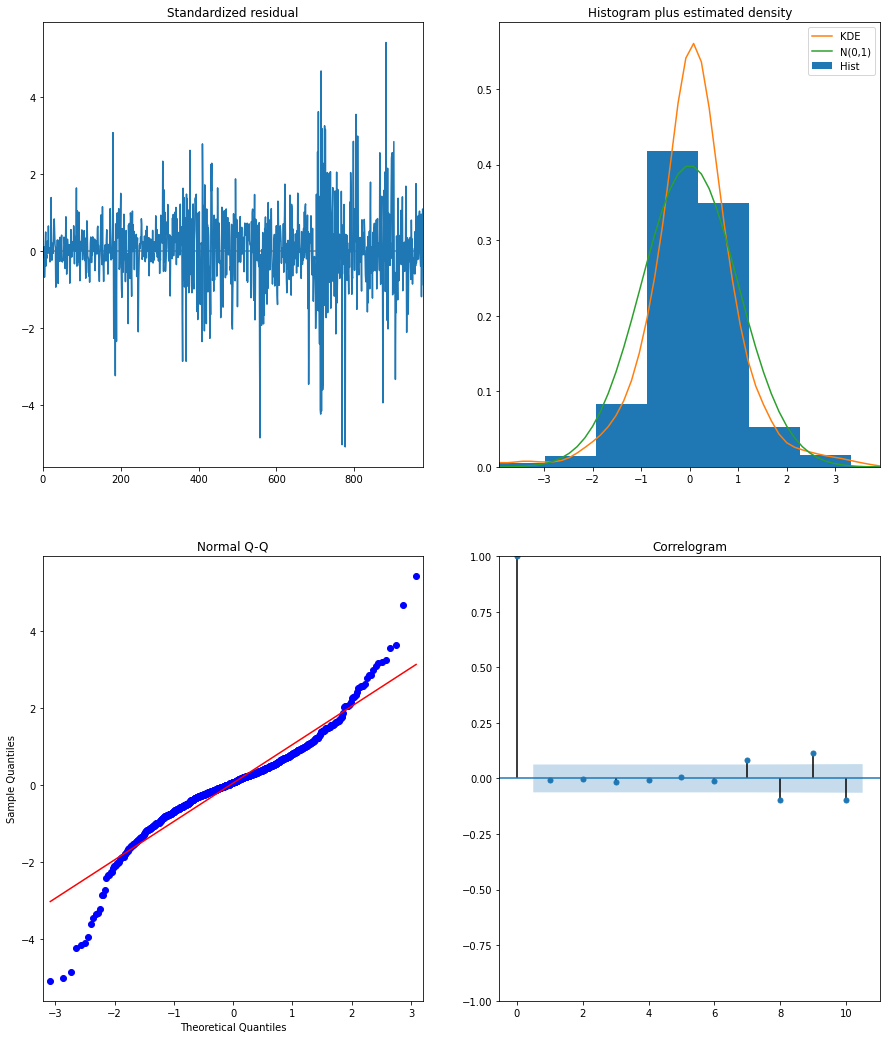

In [70]:
#one-step ahead
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

In [71]:
#one_adj_c = 'Adj Close'
def one_step(train, test, one_adj_c, pred, pred_conf):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c ]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

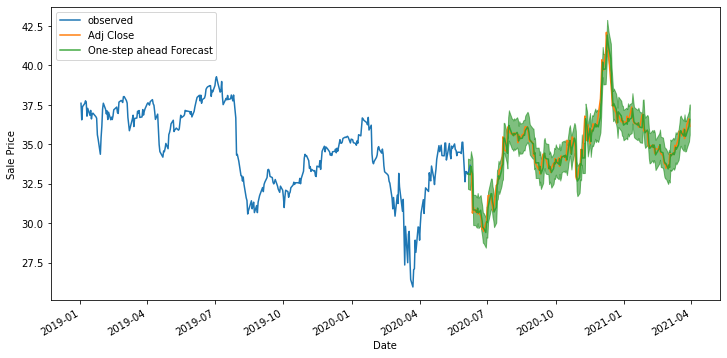

In [72]:
#re-run
#one_step_forecast = one_step(train, test, one_adj_c, pred,pred_conf)
one_step_forecast = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

In [73]:
def metric_func_one(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

    # Compute the root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [74]:
metric_func_one(pred, test, adj_close)

The Mean Squared Error of our forecasts is 0.32
The Root Mean Squared Error of our forecasts is 0.56


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1018
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -709.865
Date:                              Tue, 30 Mar 2021   AIC                           1437.729
Time:                                      13:38:46   BIC                           1481.708
Sample:                                           0   HQIC                          1454.462
                                             - 1018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1357      0.332      3.417      0.001       0.484       1.787
ar.L2         -0.3996      0.350     -1.141      0.254      -1.086       0.287
ar.L3          0.2518      0.262      0.963      0.336      -0.261       0.764
ma.L1         -0.2137      0.331     -0.646      0.518      -0.862       0.435
ma.L2          0.3225      0.254      1.272      0.203      -0.174       0.819
ar.S.L12       0.0368      0.029      1.277      0.201      -0.020       0.093
ar.S.L24      -0.0522      0.027     -1.962      0.050      -0.104   -5.53e-05
ma.S.L12      -0.9999      2.076     -0.482      0.630      -5.068       3.068
sigma2         0.2368      0.490      0.483      0.629      -0.724       1.198
===================================================================================
Ljung-Box (Q):                       80.39   Jarque-Bera (JB):              1026.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


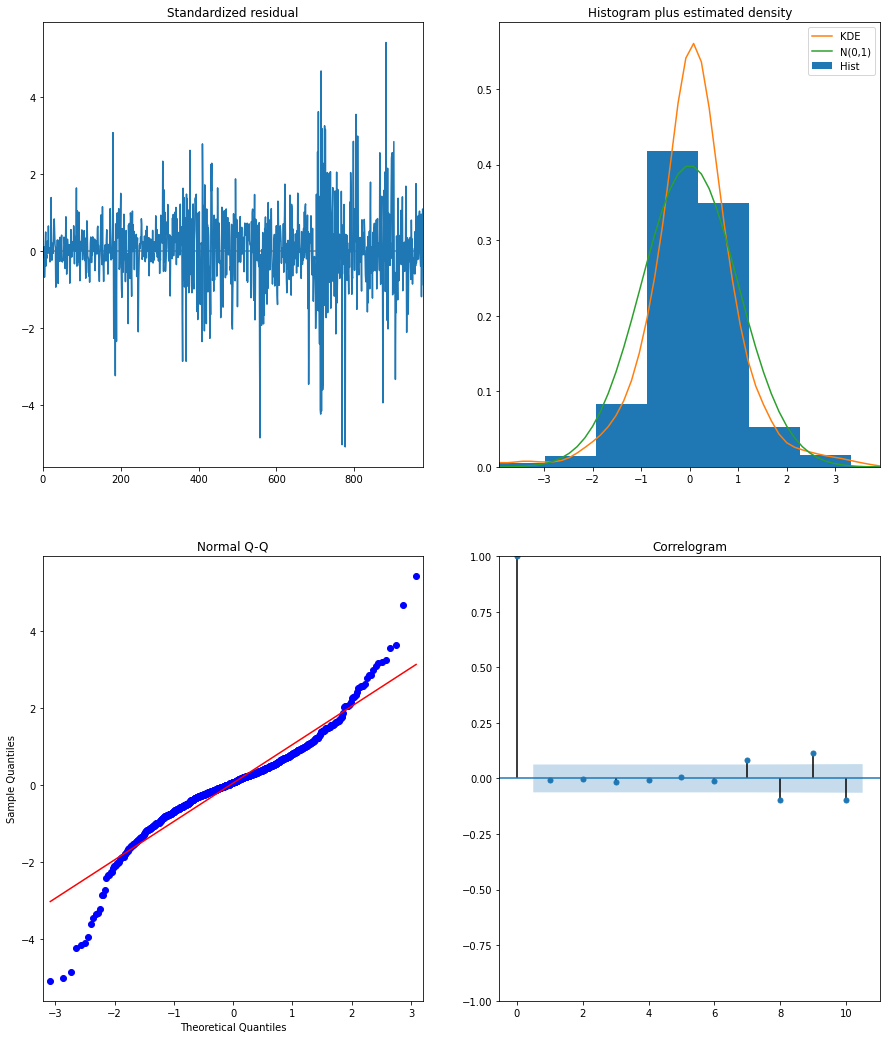

In [75]:
#dynamic forecasting
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

In [76]:
def prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test):
    plt.figure(figsize=(12,6))
    # Plot observed values

    #ax = train['Adj Close']['2019':].plot(label='observed')
    ax = train[one_adj_c]['2019':].plot(label='observed')#
    #test['Adj Close']['2019':].plot()#label='Test'
    test[one_adj_c]['2019':].plot()#label='Test'
    # Plot predicted values
    pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', alpha=0.9)

    # Plot the range for confidence intervals
    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Sale Price')
    plt.legend()

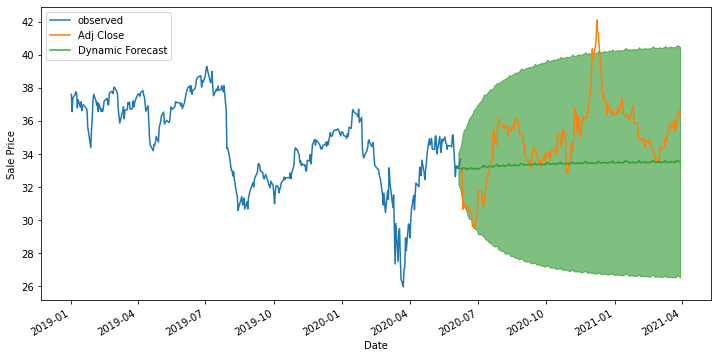

In [77]:
"""
test:
2020-11-02    33.657753
2021-03-25    35.410000
"""
#one_step_forecast = one_step(train=train, test=test, one_adj_c='Adj Close', pred=pred,pred_conf=pred_conf)
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test, one_adj_c= adj_close)#'Adj Close'


In [78]:
"""
def metric_func(pred, test, sarima_col):
    # Get the real and predicted values
    forecast = pred.predicted_mean
    actual =test[sarima_col]['1996':] #actual =test['Adj Close']['1996':]

    # Compute the root mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))


"""
def metric_func_dynamic(pred_dynamic, test, sarima_col):
# Get the real and predicted values
    forecast = pred_dynamic.predicted_mean
    actual = test[sarima_col]#['1996':] #history_type

    # Compute the mean square error
    mse = ((forecast - actual) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    #np.sqrt(np.mean((predictions-targets)**2))
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [79]:
metric_func_dynamic(pred_dynamic, test, adj_close)

The Mean Squared Error of our forecasts is 6.65
The Root Mean Squared Error of our forecasts is 2.58


#### Pfizer / MA_50

In [80]:
#sarima_df

In [81]:
#sarima_col_1 = 'MA_50'

In [82]:
# #stepwise_fit = arima_model(train['Adj Close'])
# stepwise_fit = arima_model(train[sarima_col_1])

In [83]:
#stepwise_fit.summary()

In [84]:
# arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
# for col in sarima_df.columns:
#   zip_test_2 = arima_model(sarima_df[col])
#   arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
# #result   
# output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
# output_df  

In [85]:
# def fit_ARIMA(df, order=None, seasonal_order=None):
#     """
#     forecasting statsmodel SARIMAX model
#     """
#     ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
#                                         order=order, 
#                                         seasonal_order=seasonal_order, 
#                                         enforce_stationarity=False, 
#                                         enforce_invertibility=False)

#     # Fit the model and print results
#     output = ARIMA_MODEL.fit()

#     #display / no tables 1
#     display(output.summary())
    
#     print('\n')
#     print('MODEL DIAGNOSTICS')
    
#     output.plot_diagnostics(figsize=(15, 18));
#     plt.show()
    
#     return output

In [86]:
# #train['Adj Close'][[0,-1]]
# train[sarima_col_1][[0,-1]]

In [87]:
# #test['Adj Close'][[0,-1]]
# test[sarima_col_1][[0,-1]]

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1018
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2643.837
Date:                                 Tue, 30 Mar 2021   AIC                          -5265.673
Time:                                         13:39:05   BIC                          -5211.933
Sample:                                              0   HQIC                         -5245.226
                                                - 1018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4262      0.133     18.258      0.000       2.166       2.687
ar.L2         -1.9272      0.254     -7.601      0.000      -2.424      -1.430
ar.L3          0.4984      0.121      4.104      0.000       0.260       0.736
ma.L1         -0.4618      0.132     -3.504      0.000      -0.720      -0.204
ma.L2          0.2491      0.029      8.736      0.000       0.193       0.305
ma.L3          0.0469      0.049      0.955      0.340      -0.049       0.143
ar.S.L12      -0.2963      0.029    -10.362      0.000      -0.352      -0.240
ar.S.L24       0.0055      0.027      0.199      0.842      -0.048       0.059
ma.S.L12       9.3871      0.001   1.57e+04      0.000       9.386       9.388
ma.S.L24      -1.6001      0.005   -354.407      0.000      -1.609      -1.591
sigma2      2.889e-06   1.19e-07     24.231      0.000    2.66e-06    3.12e-06
===================================================================================
Ljung-Box (Q):                      296.39   Jarque-Bera (JB):                89.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.63e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


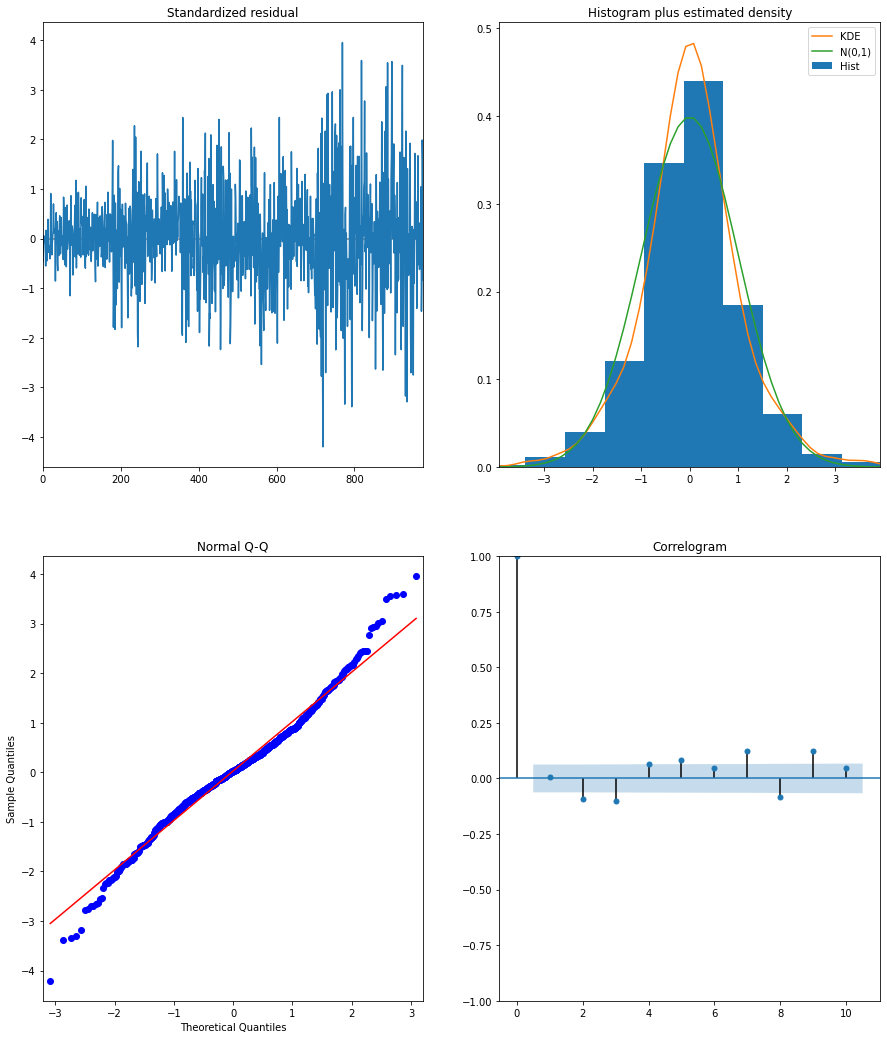

In [88]:
hist_type = ma_50 #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

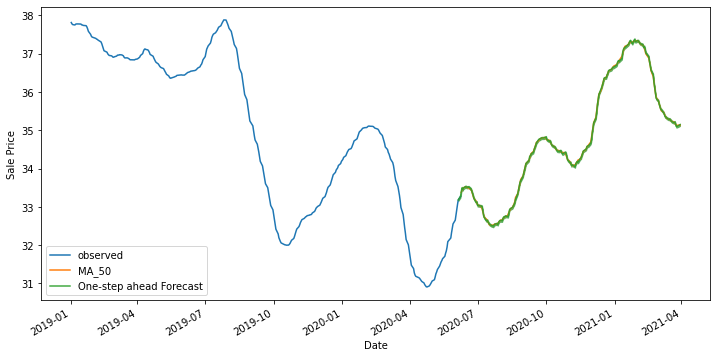

In [89]:
#one_step_forecast = one_step(train, test, col_s = sarima_col,pred,pred_conf)
#one_step_forecast = one_step(train, test, one_adj_c ,pred,pred_conf)

# one_step_forecast_1 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_1 = one_step(train=train, test=test, one_adj_c= ma_50, pred=pred,pred_conf=pred_conf)

In [90]:
metric_func_1 = metric_func_one(pred, test, ma_50)

The Mean Squared Error of our forecasts is 0.0
The Root Mean Squared Error of our forecasts is 0.02


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1018
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2643.837
Date:                                 Tue, 30 Mar 2021   AIC                          -5265.673
Time:                                         13:39:20   BIC                          -5211.933
Sample:                                              0   HQIC                         -5245.226
                                                - 1018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4262      0.133     18.258      0.000       2.166       2.687
ar.L2         -1.9272      0.254     -7.601      0.000      -2.424      -1.430
ar.L3          0.4984      0.121      4.104      0.000       0.260       0.736
ma.L1         -0.4618      0.132     -3.504      0.000      -0.720      -0.204
ma.L2          0.2491      0.029      8.736      0.000       0.193       0.305
ma.L3          0.0469      0.049      0.955      0.340      -0.049       0.143
ar.S.L12      -0.2963      0.029    -10.362      0.000      -0.352      -0.240
ar.S.L24       0.0055      0.027      0.199      0.842      -0.048       0.059
ma.S.L12       9.3871      0.001   1.57e+04      0.000       9.386       9.388
ma.S.L24      -1.6001      0.005   -354.407      0.000      -1.609      -1.591
sigma2      2.889e-06   1.19e-07     24.231      0.000    2.66e-06    3.12e-06
===================================================================================
Ljung-Box (Q):                      296.39   Jarque-Bera (JB):                89.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.63e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


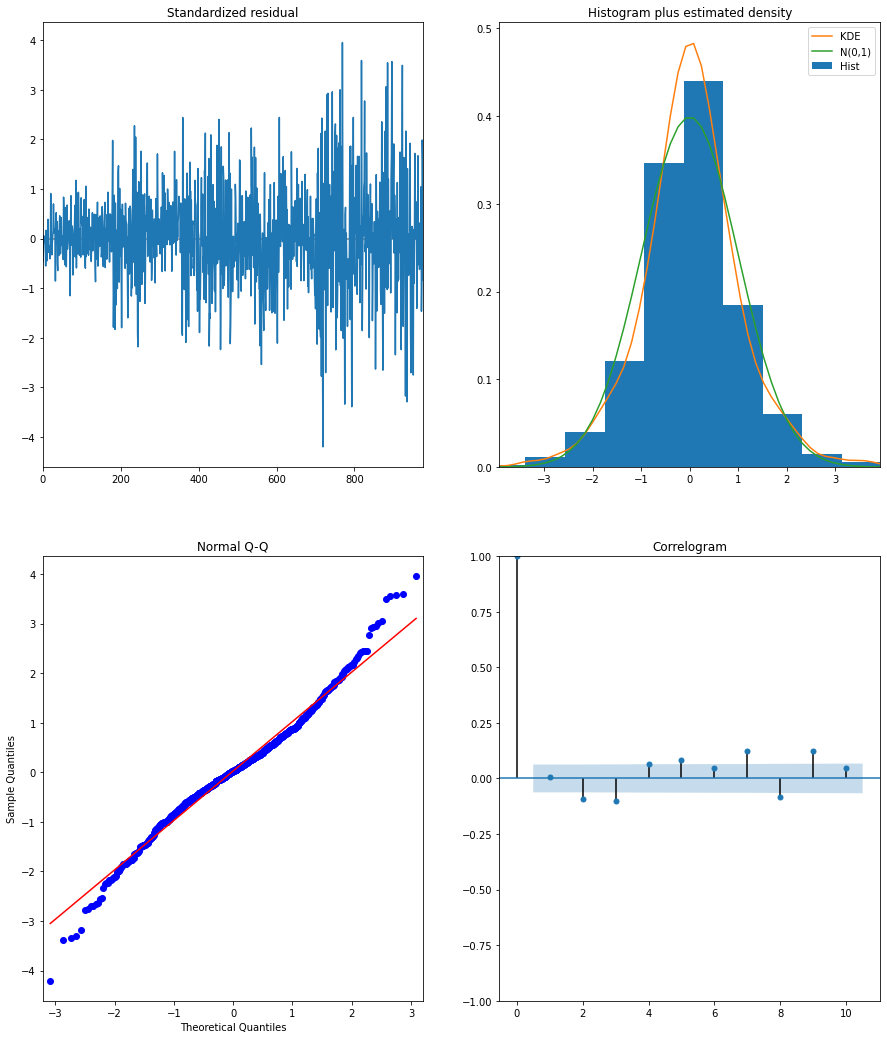

In [91]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

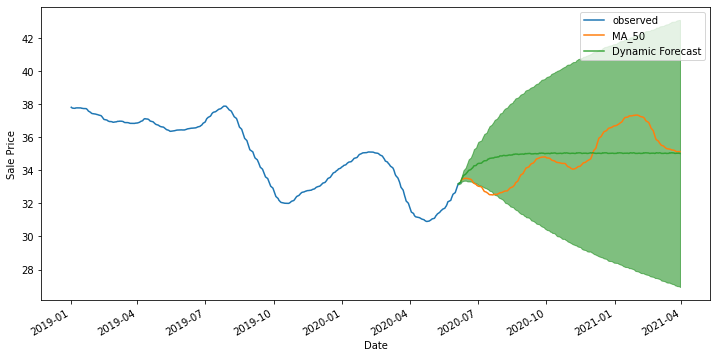

In [92]:
#prediction_visual_1 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, s_col=sarima_col,test)

# prediction_visual_2 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_2
prediction_visual_1 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= 'MA_50')

In [93]:
# # Get the real and predicted values
# forecast = pred_dynamic.predicted_mean
# actual = test[sarima_col_1]#['1996':]

# # Compute the mean square error
# mse = ((forecast - actual) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast - actual) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [94]:
metric_func_dynamic(pred_dynamic, test, ma_50)

The Mean Squared Error of our forecasts is 1.82
The Root Mean Squared Error of our forecasts is 1.35


#### Pfizer / Actual_Changes

In [95]:
#sarima_col_2 = 'Actual_Changes'

In [96]:
#stepwise_fit1 = arima_model(train[sarima_col_2])

In [97]:
#stepwise_fit1.summary()

In [98]:
# arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
# for col in sarima_df.columns:
#   zip_test_2 = arima_model(sarima_df[col])
#   arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
# #result   
# output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
# output_df  

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1018
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -711.101
Date:                              Tue, 30 Mar 2021   AIC                           1436.203
Time:                                      13:39:28   BIC                           1470.487
Sample:                                           0   HQIC                          1449.239
                                             - 1018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8810      0.043    -20.708      0.000      -0.964      -0.798
ma.L1          0.8280      0.046     18.074      0.000       0.738       0.918
ma.L2         -0.0093      0.029     -0.327      0.744      -0.065       0.047
ma.L3          0.0927      0.023      4.051      0.000       0.048       0.138
ar.S.L12       0.0461      0.028      1.620      0.105      -0.010       0.102
ma.S.L12      -1.0000     44.513     -0.022      0.982     -88.244      86.244
sigma2         0.2334     10.389      0.022      0.982     -20.130      20.596
===================================================================================
Ljung-Box (Q):                       68.98   Jarque-Bera (JB):              1012.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


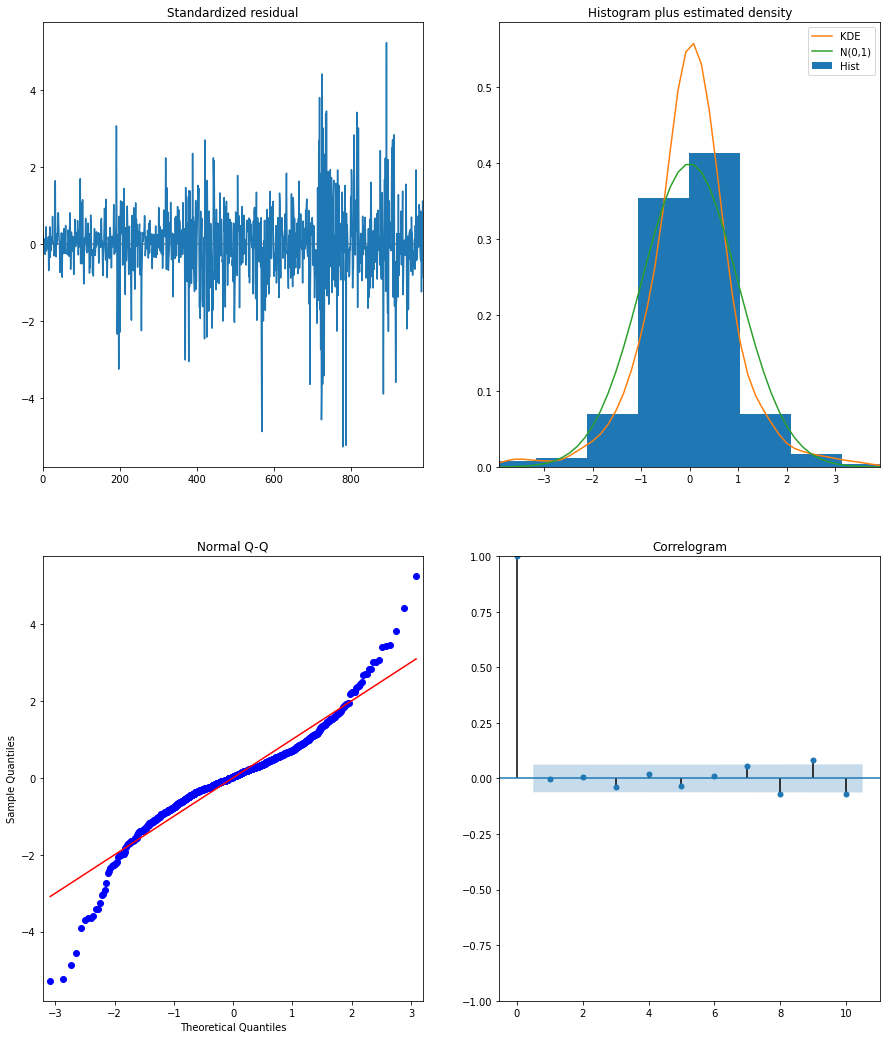

In [99]:
hist_type = actual_changes  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

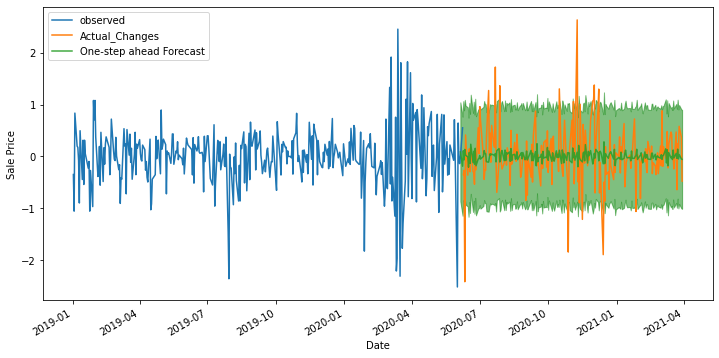

In [100]:
#col_s
#changei price
#price isn't didn't change much
#one_adj_c = 'Actual_Changes'
#one_step_forecast_2 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_2 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)

In [101]:
#.57 more or less
metric_func_2 = metric_func_one(pred, test, actual_changes)

The Mean Squared Error of our forecasts is 0.32
The Root Mean Squared Error of our forecasts is 0.56


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1018
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -711.101
Date:                              Tue, 30 Mar 2021   AIC                           1436.203
Time:                                      13:39:35   BIC                           1470.487
Sample:                                           0   HQIC                          1449.239
                                             - 1018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8810      0.043    -20.708      0.000      -0.964      -0.798
ma.L1          0.8280      0.046     18.074      0.000       0.738       0.918
ma.L2         -0.0093      0.029     -0.327      0.744      -0.065       0.047
ma.L3          0.0927      0.023      4.051      0.000       0.048       0.138
ar.S.L12       0.0461      0.028      1.620      0.105      -0.010       0.102
ma.S.L12      -1.0000     44.513     -0.022      0.982     -88.244      86.244
sigma2         0.2334     10.389      0.022      0.982     -20.130      20.596
===================================================================================
Ljung-Box (Q):                       68.98   Jarque-Bera (JB):              1012.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


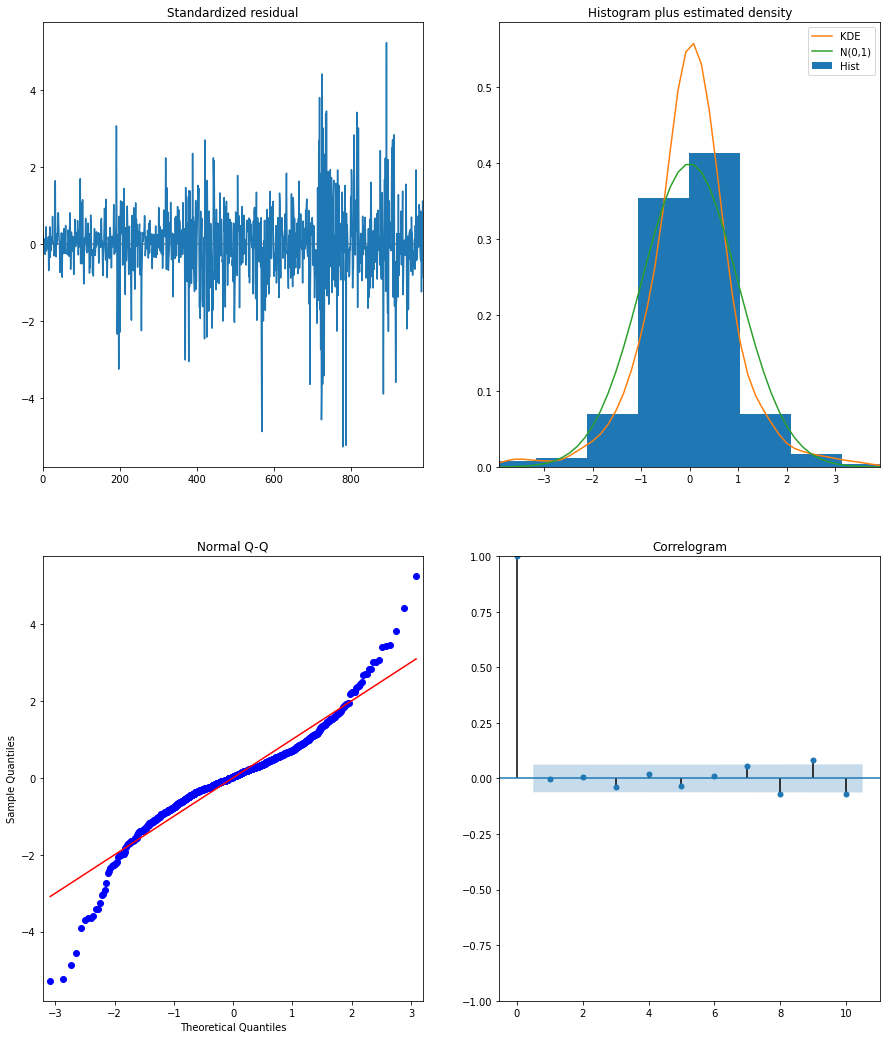

In [102]:
history_type = actual_changes  #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

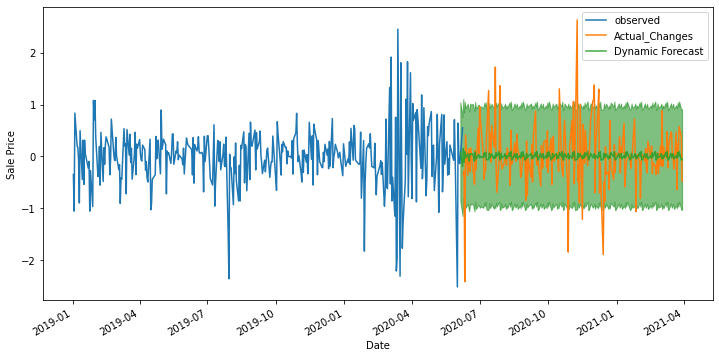

In [103]:
#s_col
#green confoience intervals
# one_adj_c = 'Actual_Changes'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_3 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [104]:
# # Get the real and predicted values
# forecast = pred_dynamic.predicted_mean
# actual = test[sarima_col_2]#['1996':]

# # Compute the mean square error
# mse = ((forecast - actual) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
# #np.sqrt(np.mean((predictions-targets)**2))
# rmse = np.sqrt(np.mean((forecast - actual) ** 2))
# print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

In [105]:
metric_func_dynamic(pred_dynamic, test, actual_changes)

The Mean Squared Error of our forecasts is 0.32
The Root Mean Squared Error of our forecasts is 0.56


#### BNTX / Adj Close

Dataframe has 370 rows and 6 columns



High        Low        Open       Close   Volume   Adj Close
Date                                                                          
2019-10-10   16.698999  13.010000   16.500000   14.240000  2805800   14.240000
2019-10-11   15.340000  13.500000   15.340000   13.820000  1364300   13.820000
2019-10-14   13.910000  12.525000   13.830000   12.750000   899100   12.750000
2019-10-15   13.000000  12.530000   12.990000   12.920000   484700   12.920000
2019-10-16   13.880000  12.610000   13.200000   12.940000   524200   12.940000
...                ...        ...         ...         ...      ...         ...
2021-03-24  101.480003  93.389999  100.239998   94.050003  2204100   94.050003
2021-03-25   97.449997  92.931000   94.099998   95.129997  1299400   95.129997
2021-03-26   97.540001  93.820000   97.500000   95.760002   908300   95.760002
2021-03-29   98.870003  93.760002   97.540001   95.910004  1061900   95.910004
2021-03-30  106.459999  98.599998   99.800003  105.734596  2196889  105.734596

[370 rows x 6 columns]

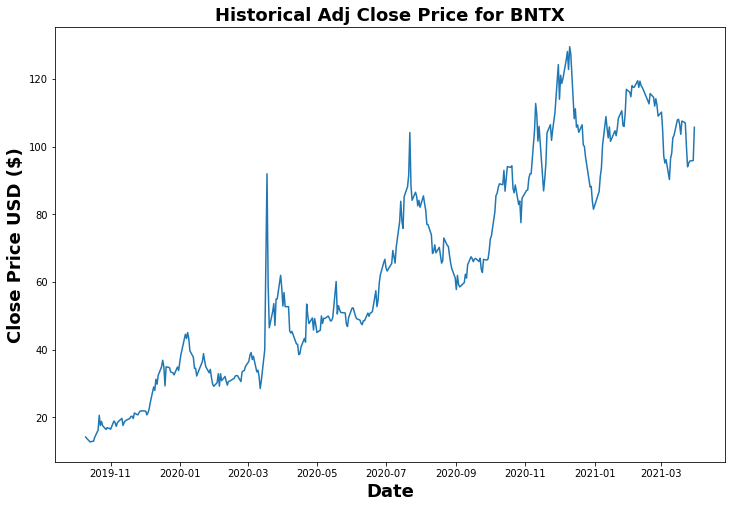

In [106]:
start='01-01-2017'
end='today'
bntx_stock = single_stock_data('BNTX', start= start,end='today',plot=True,stock_value='Adj Close')
bntx_stock

In [107]:
bntx_df = delta_data(bntx_stock,col='Adj Close')
train = bntx_df[:int(0.8*(len(bntx_df)))]
test = bntx_df[int(0.8*(len(bntx_df))):]

In [108]:
train

High         Low        Open       Close   Volume  \
Date                                                                  
2019-12-19   33.869999   27.728001   33.869999   29.340000   250500   
2019-12-20   34.970001   31.809999   31.809999   34.970001   447900   
2019-12-23   35.900002   33.099998   34.910000   34.730000   103500   
2019-12-24   34.610001   33.009998   34.610001   33.470001    23900   
2019-12-26   34.000000   31.591000   33.290001   33.200001    53900   
...                ...         ...         ...         ...      ...   
2020-12-17  107.589996  101.620003  102.635002  106.430000  3487800   
2020-12-18  106.769997  102.570000  106.459999  104.239998  3108200   
2020-12-21  107.970001  104.570000  107.510002  106.459999  2611000   
2020-12-22  107.209999   95.599998  107.070000  100.559998  5021000   
2020-12-23  100.500000   95.000000   97.120003  100.059998  3414000   

             Adj Close  Actual_Changes  Percent_Chg       MA_50  
Date                                                             
2019-12-19   29.340000       -5.660000    -0.161714   20.794800  
2019-12-20   34.970001        5.630001     0.191888   21.209400  
2019-12-23   34.730000       -0.240002    -0.006863   21.627600  
2019-12-24   33.470001       -1.259998    -0.036280   22.042000  
2019-12-26   33.200001       -0.270000    -0.008067   22.447600  
...                ...             ...          ...         ...  
2020-12-17  106.430000        0.650002     0.006145  100.674199  
2020-12-18  104.239998       -2.190002    -0.020577  100.999999  
2020-12-21  106.459999        2.220001     0.021297  101.348399  
2020-12-22  100.559998       -5.900002    -0.055420  101.584799  
2020-12-23  100.059998       -0.500000    -0.004972  101.725999  

[256 rows x 9 columns]

In [109]:
#sarima_col_3 = 'Adj Close'

# arima_list = [['hist', 'pdq','seasonal_pdq','aic']] 
# for col in bntx_df.columns:
#   zip_test_2 = arima_model(bntx_df[col])
#   arima_list.append([col,zip_test_2.order, zip_test_2.seasonal_order, zip_test_2.aic()])
# #result   
# output_df = pd.DataFrame(arima_list[1:],columns=arima_list[0]) 
# output_df  

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  321
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -870.160
Date:                              Tue, 30 Mar 2021   AIC                           1758.320
Time:                                      13:39:50   BIC                           1791.097
Sample:                                           0   HQIC                          1771.464
                                              - 321                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1291      0.431      2.617      0.009       0.283       1.975
ar.L2         -0.5960      0.492     -1.212      0.225      -1.560       0.368
ar.L3          0.4492      0.373      1.205      0.228      -0.281       1.180
ma.L1         -0.1026      0.442     -0.232      0.816      -0.968       0.763
ma.L2          0.3343      0.402      0.832      0.405      -0.453       1.122
ar.S.L12      -0.0721      0.079     -0.917      0.359      -0.226       0.082
ar.S.L24      -0.0002      0.070     -0.003      0.998      -0.138       0.138
ma.S.L12      -0.9406      0.072    -13.088      0.000      -1.081      -0.800
sigma2        26.2455      2.048     12.818      0.000      22.232      30.259
===================================================================================
Ljung-Box (Q):                       25.93   Jarque-Bera (JB):               438.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.04
Prob(H) (two-sided):                  0.41   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


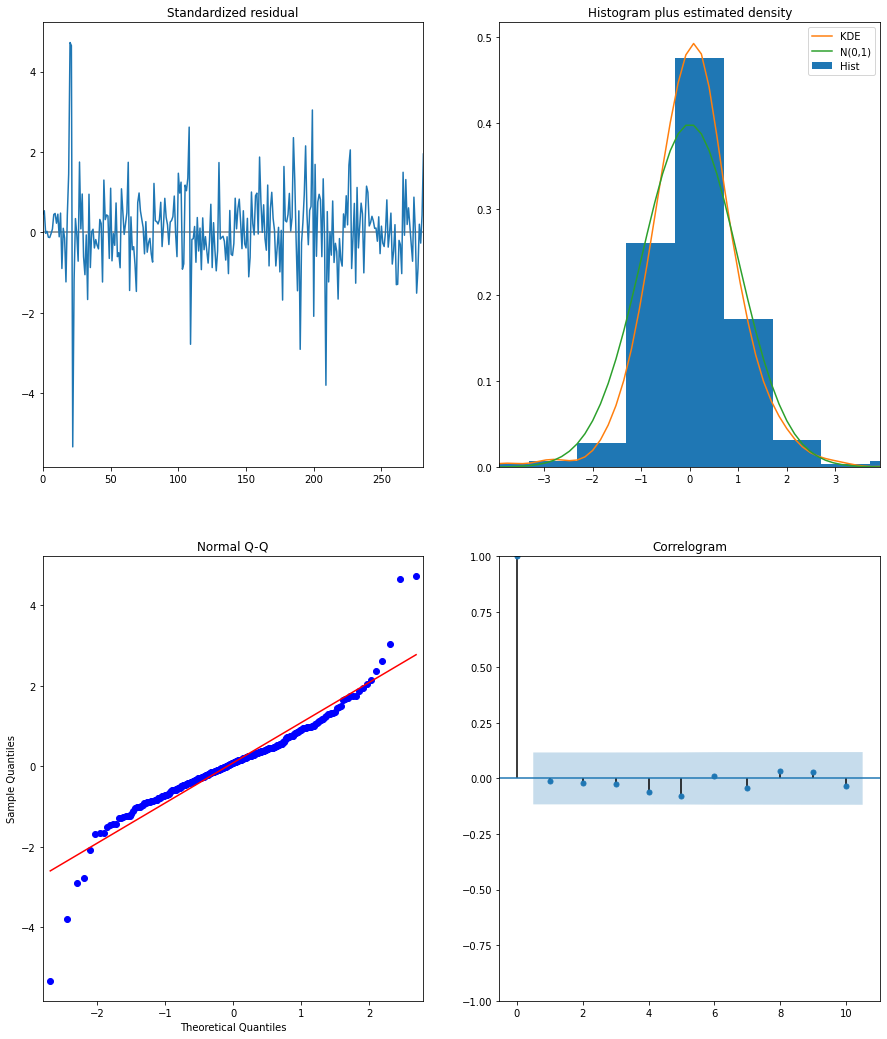

In [110]:
hist_type = adj_close #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

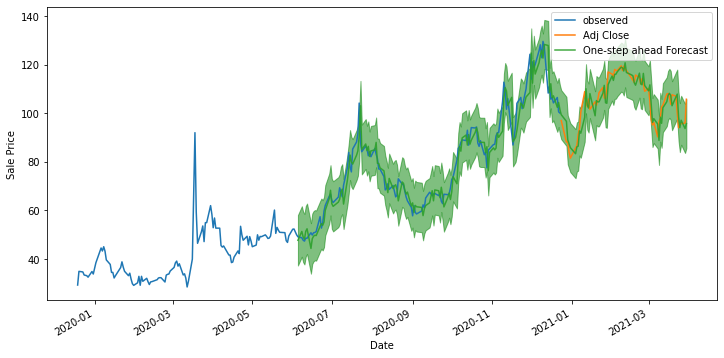

In [111]:
#blue actual
#green line is forecast
#orange-test 
#green shade confidence interval
#one_adj_c = 'Adj Close'
#one_step_forecast_4 = one_step(train, test, one_adj_c,pred,pred_conf)
one_step_forecast_4 = one_step(train=train, test=test, one_adj_c= adj_close, pred=pred,pred_conf=pred_conf)

In [112]:
#metric_func(pred, test,bntx_df)
#metric_func_2 = metric_func(pred, test, sarima_col_2)
metric_func_one(pred, test, adj_close)

The Mean Squared Error of our forecasts is 16.79
The Root Mean Squared Error of our forecasts is 4.1


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                  321
Model:             SARIMAX(3, 0, 2)x(2, 1, [1], 12)   Log Likelihood                -870.160
Date:                              Tue, 30 Mar 2021   AIC                           1758.320
Time:                                      13:40:04   BIC                           1791.097
Sample:                                           0   HQIC                          1771.464
                                              - 321                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1291      0.431      2.617      0.009       0.283       1.975
ar.L2         -0.5960      0.492     -1.212      0.225      -1.560       0.368
ar.L3          0.4492      0.373      1.205      0.228      -0.281       1.180
ma.L1         -0.1026      0.442     -0.232      0.816      -0.968       0.763
ma.L2          0.3343      0.402      0.832      0.405      -0.453       1.122
ar.S.L12      -0.0721      0.079     -0.917      0.359      -0.226       0.082
ar.S.L24      -0.0002      0.070     -0.003      0.998      -0.138       0.138
ma.S.L12      -0.9406      0.072    -13.088      0.000      -1.081      -0.800
sigma2        26.2455      2.048     12.818      0.000      22.232      30.259
===================================================================================
Ljung-Box (Q):                       25.93   Jarque-Bera (JB):               438.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.04
Prob(H) (two-sided):                  0.41   Kurtosis:                         9.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


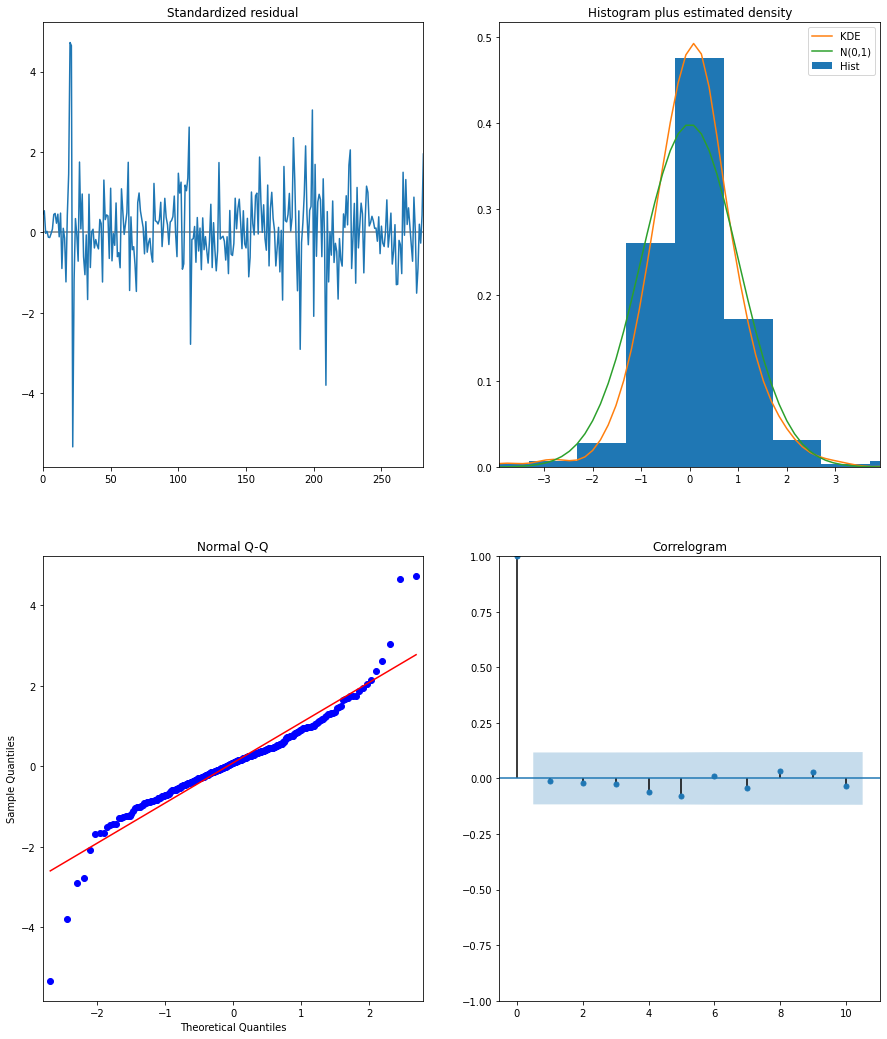

In [113]:
history_type = adj_close #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

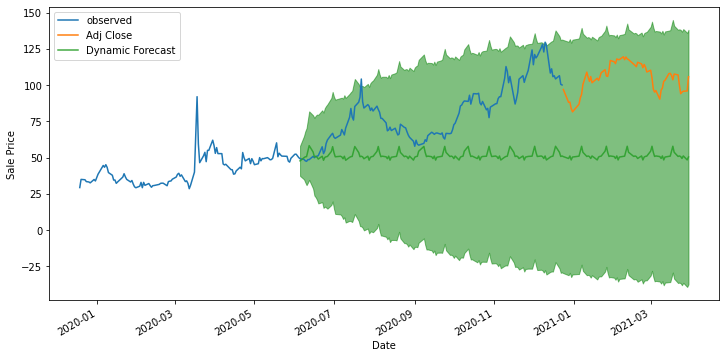

In [114]:
#gren line is forcast
#green shades gives more range for forecast
#one_adj_c = 'Adj Close'
# prediction_visual_3 = prediction_vis(pred_dynamic,pred_dynamic_conf,train, one_adj_c,test)
# prediction_visual_3
prediction_visual_4 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= adj_close)


In [115]:
metric_func_dynamic(pred_dynamic, test, adj_close)

The Mean Squared Error of our forecasts is 2930.77
The Root Mean Squared Error of our forecasts is 54.14


#### BNTX / MA_50

In [116]:
"""
adj_close = 'Adj Close'
ma_50 = 'MA_50'
actual_changes = 'Actual_Changes'
"""

#sar_ma_50 = 'MA_50'

"\nadj_close = 'Adj Close'\nma_50 = 'MA_50'\nactual_changes = 'Actual_Changes'\n"

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                 1018
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                2643.837
Date:                                 Tue, 30 Mar 2021   AIC                          -5265.673
Time:                                         13:40:21   BIC                          -5211.933
Sample:                                              0   HQIC                         -5245.226
                                                - 1018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.4262      0.133     18.258      0.000       2.166       2.687
ar.L2         -1.9272      0.254     -7.601      0.000      -2.424      -1.430
ar.L3          0.4984      0.121      4.104      0.000       0.260       0.736
ma.L1         -0.4618      0.132     -3.504      0.000      -0.720      -0.204
ma.L2          0.2491      0.029      8.736      0.000       0.193       0.305
ma.L3          0.0469      0.049      0.955      0.340      -0.049       0.143
ar.S.L12      -0.2963      0.029    -10.362      0.000      -0.352      -0.240
ar.S.L24       0.0055      0.027      0.199      0.842      -0.048       0.059
ma.S.L12       9.3871      0.001   1.57e+04      0.000       9.386       9.388
ma.S.L24      -1.6001      0.005   -354.407      0.000      -1.609      -1.591
sigma2      2.889e-06   1.19e-07     24.231      0.000    2.66e-06    3.12e-06
===================================================================================
Ljung-Box (Q):                      296.39   Jarque-Bera (JB):                89.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.13   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.63e+21. Standard errors may be unstable.
"""



MODEL DIAGNOSTICS


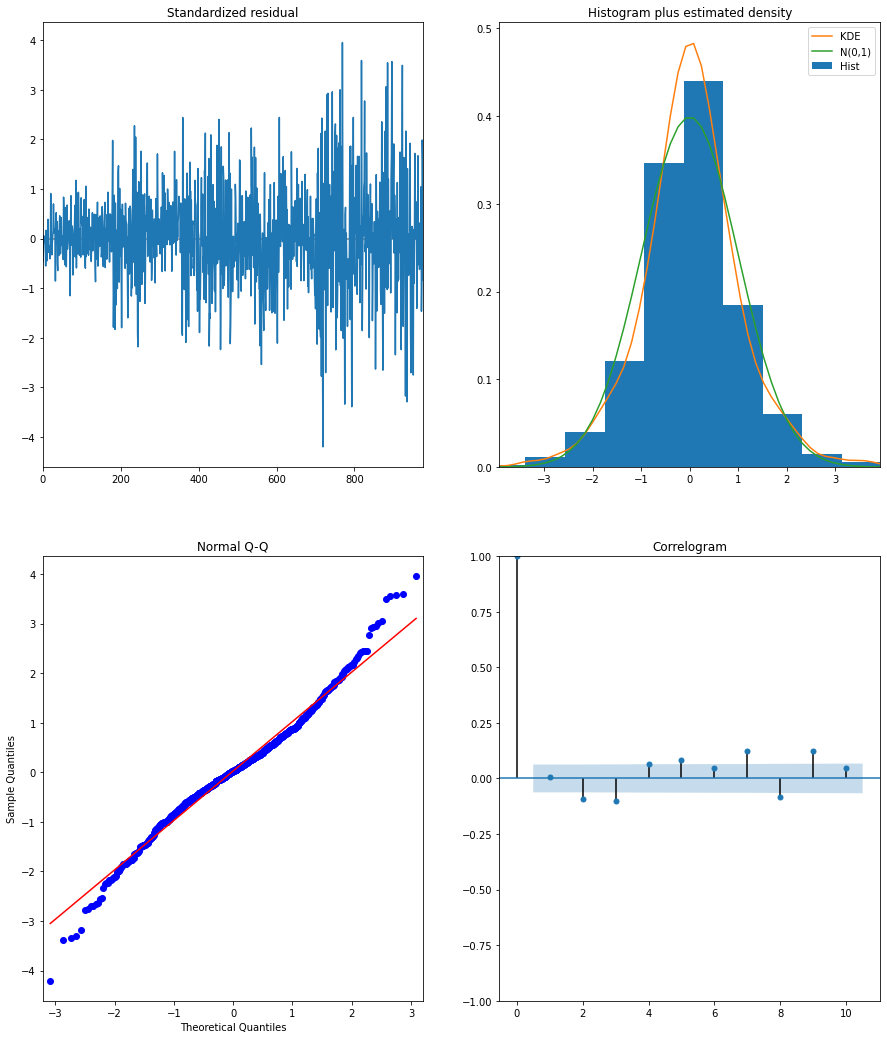

In [117]:
hist_type = ma_50  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

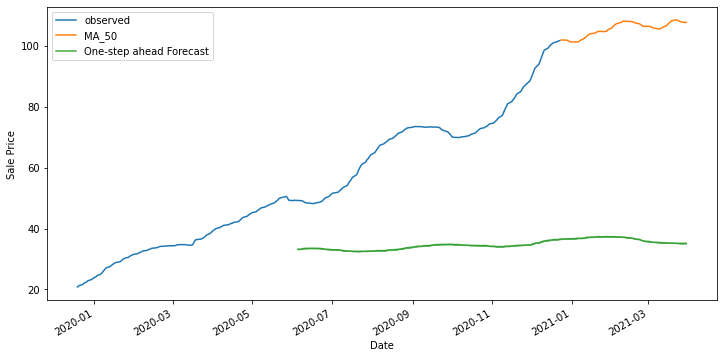

In [118]:
#MA_50'
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= 'MA_50', pred=pred,pred_conf=pred_conf)#'MA_50'


In [119]:
metric_func_one(pred, test, ma_50)

The Mean Squared Error of our forecasts is 4802.79
The Root Mean Squared Error of our forecasts is 69.3


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   MA_50   No. Observations:                  321
Model:             SARIMAX(3, 0, 3)x(2, 1, [1, 2], 12)   Log Likelihood                 128.306
Date:                                 Tue, 30 Mar 2021   AIC                           -234.612
Time:                                         13:40:29   BIC                           -194.590
Sample:                                              0   HQIC                          -218.561
                                                 - 321                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9444      0.629      3.092      0.002       0.712       3.177
ar.L2         -0.9553      1.205     -0.793      0.428      -3.318       1.407
ar.L3          0.0094      0.578      0.016      0.987      -1.124       1.142
ma.L1          0.1482      0.624      0.238      0.812      -1.074       1.371
ma.L2         -0.0616      0.124     -0.496      0.620      -0.305       0.182
ma.L3         -0.1134      0.086     -1.321      0.186      -0.282       0.055
ar.S.L12      -0.5984      0.311     -1.922      0.055      -1.209       0.012
ar.S.L24      -0.2983      0.089     -3.355      0.001      -0.473      -0.124
ma.S.L12       7.1761     28.239      0.254      0.799     -48.172      62.524
ma.S.L24      -2.7246      8.514     -0.320      0.749     -19.413      13.963
sigma2         0.0004      0.003      0.135      0.893      -0.006       0.006
===================================================================================
Ljung-Box (Q):                       57.30   Jarque-Bera (JB):                68.67
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.05
Prob(H) (two-sided):                  0.99   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


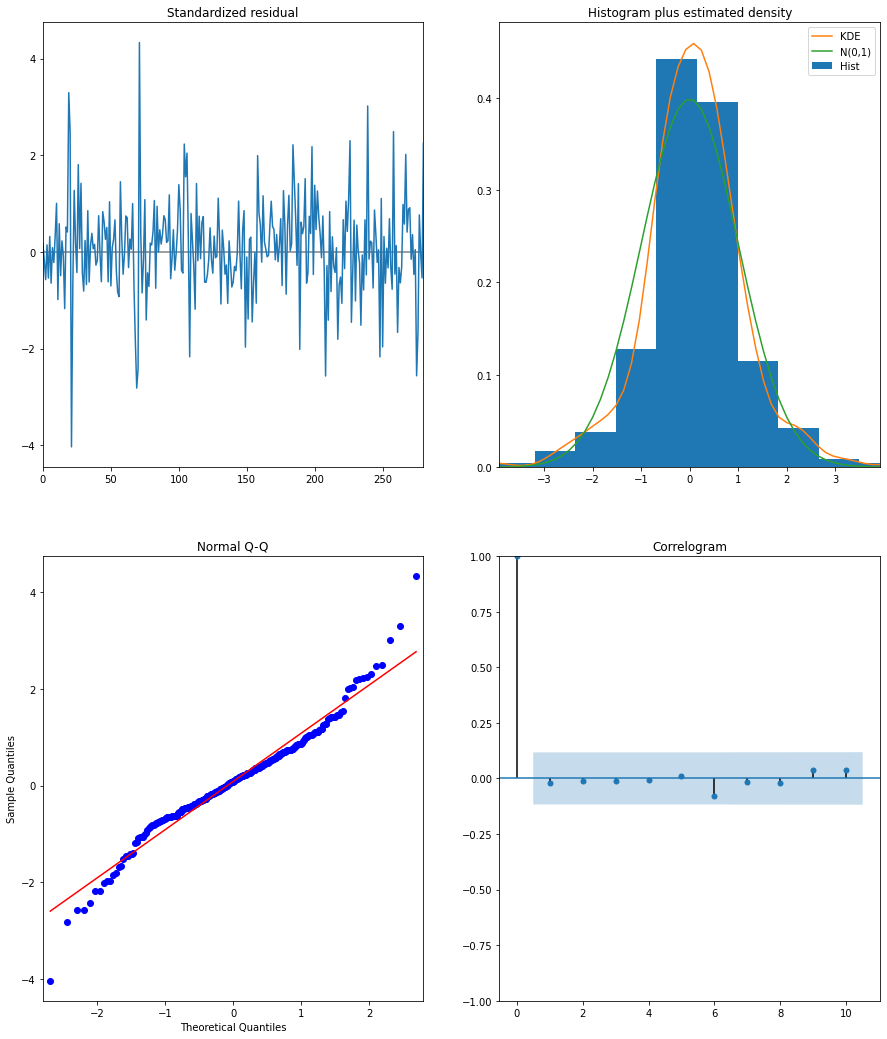

In [120]:
history_type = ma_50 #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

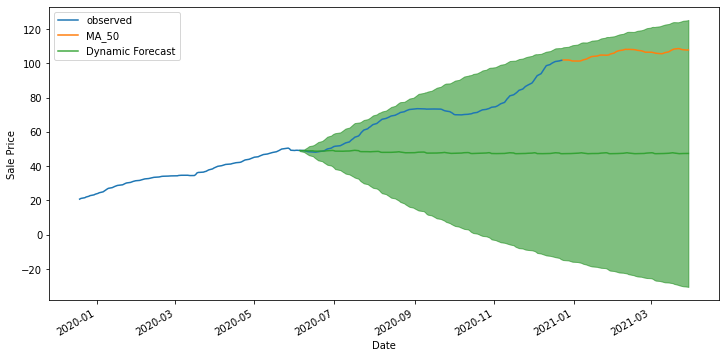

In [121]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= ma_50)


In [122]:
metric_func_dynamic(pred_dynamic, test, ma_50)

The Mean Squared Error of our forecasts is 3388.32
The Root Mean Squared Error of our forecasts is 58.21


#### BNTX / actual_changes

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                 1018
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -711.101
Date:                              Tue, 30 Mar 2021   AIC                           1436.203
Time:                                      13:40:36   BIC                           1470.487
Sample:                                           0   HQIC                          1449.239
                                             - 1018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8810      0.043    -20.708      0.000      -0.964      -0.798
ma.L1          0.8280      0.046     18.074      0.000       0.738       0.918
ma.L2         -0.0093      0.029     -0.327      0.744      -0.065       0.047
ma.L3          0.0927      0.023      4.051      0.000       0.048       0.138
ar.S.L12       0.0461      0.028      1.620      0.105      -0.010       0.102
ma.S.L12      -1.0000     44.513     -0.022      0.982     -88.244      86.244
sigma2         0.2334     10.389      0.022      0.982     -20.130      20.596
===================================================================================
Ljung-Box (Q):                       68.98   Jarque-Bera (JB):              1012.83
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


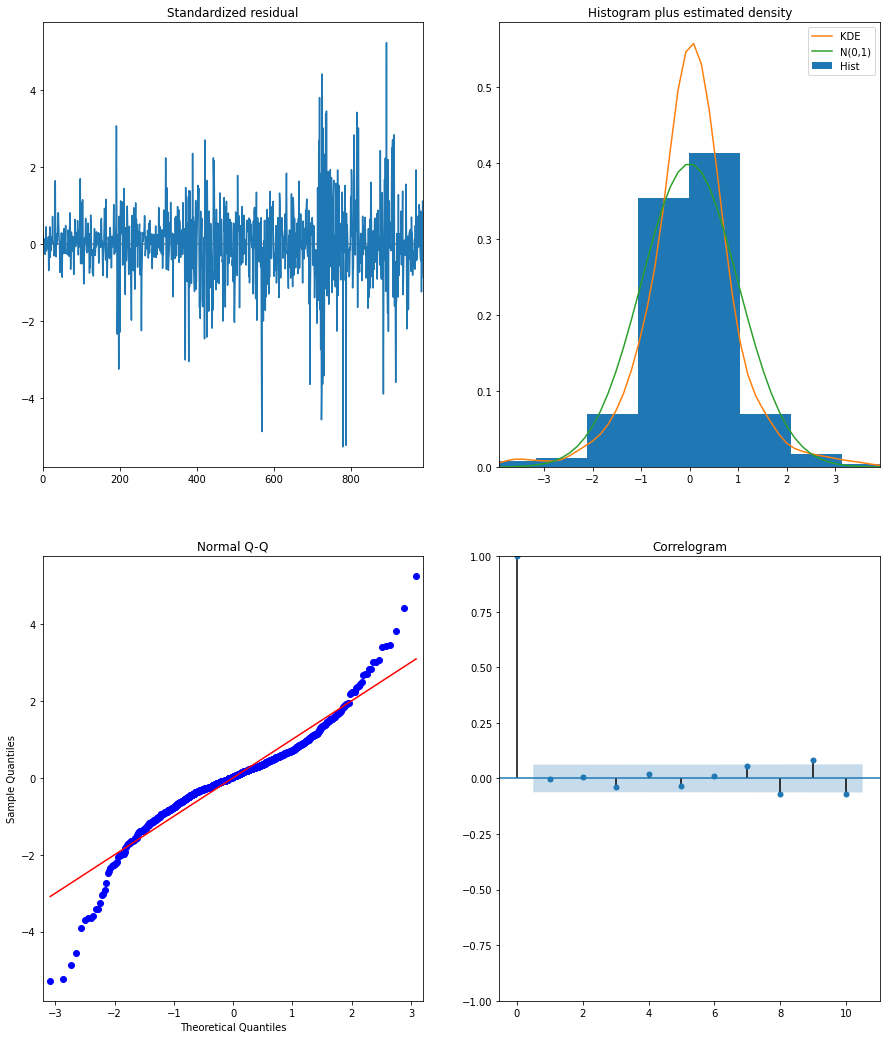

In [123]:
hist_type = actual_changes  #hist_type = 'Adj Close'
hist_params= output_df[output_df['hist']==hist_type]
hist_params.pdq.values[0]
hist_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(sarima_df[hist_type],order=hist_params.pdq.values[0], seasonal_order= hist_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 

pred = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=False)
pred_conf = pred.conf_int()

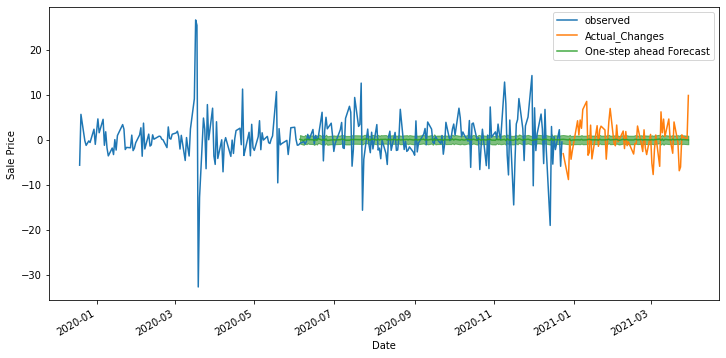

In [124]:
one_step_forecast_5 = one_step(train=train, test=test, one_adj_c= actual_changes, pred=pred,pred_conf=pred_conf)#'MA_50'


In [125]:
metric_func_one(pred, test, actual_changes)

The Mean Squared Error of our forecasts is 14.45
The Root Mean Squared Error of our forecasts is 3.8


/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Actual_Changes   No. Observations:                  321
Model:             SARIMAX(1, 0, 3)x(1, 1, [1], 12)   Log Likelihood                -899.419
Date:                              Tue, 30 Mar 2021   AIC                           1812.837
Time:                                      13:40:41   BIC                           1838.598
Sample:                                           0   HQIC                          1823.155
                                              - 321                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3708      0.690      0.538      0.591      -0.981       1.723
ma.L1         -0.3531      0.699     -0.505      0.613      -1.723       1.016
ma.L2         -0.1457      0.063     -2.301      0.021      -0.270      -0.022
ma.L3         -0.0207      0.145     -0.143      0.886      -0.304       0.263
ar.S.L12      -0.0003      0.055     -0.005      0.996      -0.109       0.108
ma.S.L12      -1.0001     37.653     -0.027      0.979     -74.800      72.799
sigma2        24.4241    919.837      0.027      0.979   -1778.422    1827.271
===================================================================================
Ljung-Box (Q):                       26.74   Jarque-Bera (JB):               463.02
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.66   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""



MODEL DIAGNOSTICS


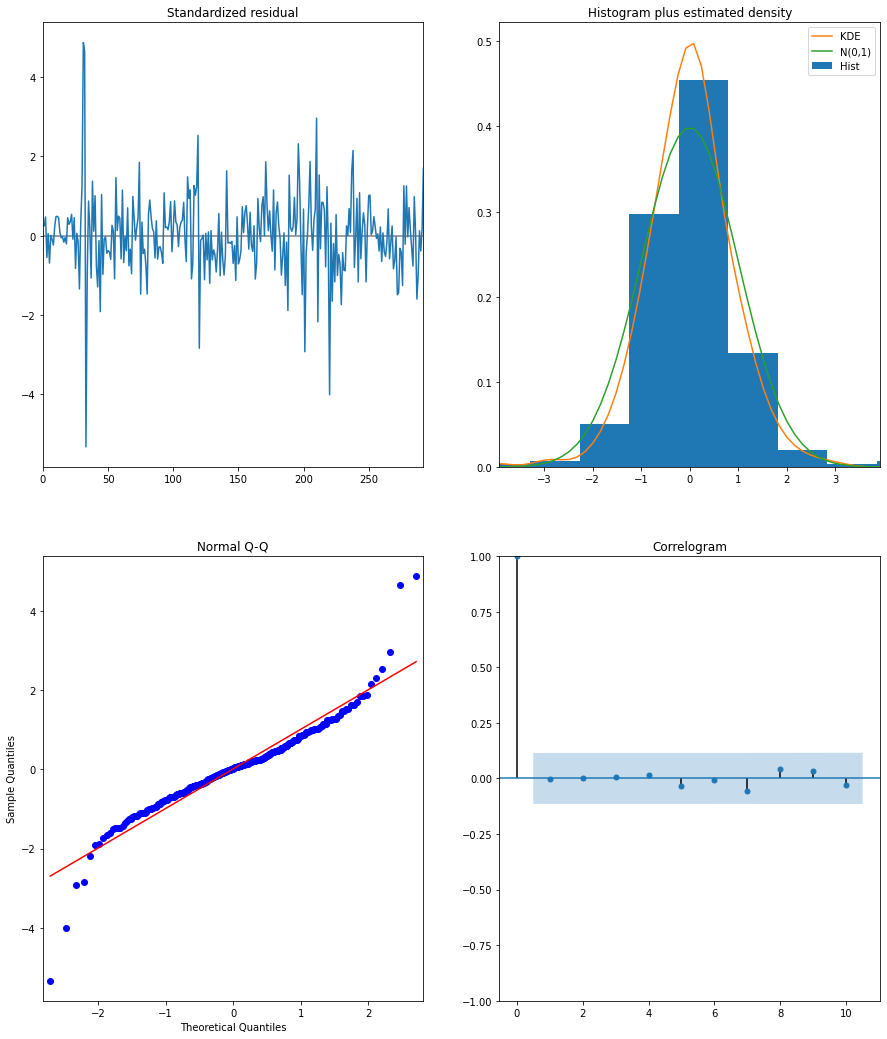

In [126]:
history_type = actual_changes #history_type = 'Adj Close'
zip_params = output_df[output_df['hist']==history_type]
zip_params.pdq.values[0]
zip_params.seasonal_pdq.values[0]

output_sarima = fit_ARIMA(bntx_df[history_type],order=zip_params.pdq.values[0] ,seasonal_order= zip_params.seasonal_pdq.values[0] )
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output_sarima.get_prediction(start=pd.to_datetime('2020-06-05'), dynamic=True,full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

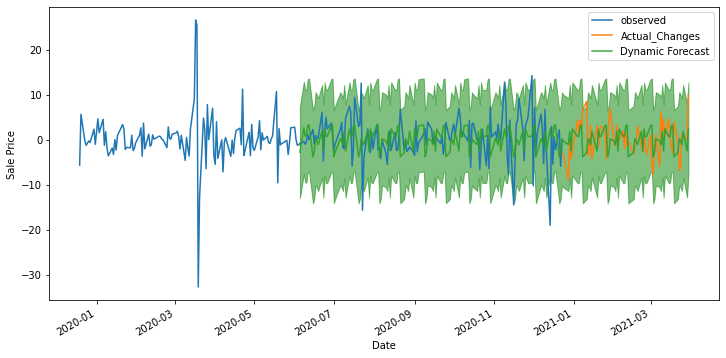

In [127]:
prediction_visual_5 = prediction_vis(pred_dynamic=pred_dynamic,pred_dynamic_conf=pred_dynamic_conf,
                                     train=train,test=test,one_adj_c= actual_changes)


In [128]:
metric_func_dynamic(pred_dynamic, test, actual_changes)

The Mean Squared Error of our forecasts is 19.58
The Root Mean Squared Error of our forecasts is 4.42


### LTSM / Multi-Stocks


In [129]:
multi_stocks

PFE         JNJ        NVAX        MRNA        AZN  \
Date                                                                   
2017-01-03  26.653324  103.436539   25.400000         NaN  23.433638   
2017-01-04  26.887548  103.266876   26.200001         NaN  23.619688   
2017-01-05  27.146002  104.347321   26.400000         NaN  24.262403   
2017-01-06  27.041008  103.847282   27.400000         NaN  24.042524   
2017-01-09  27.032928  103.829422   28.400000         NaN  24.127094   
...               ...         ...         ...         ...        ...   
2021-03-24  35.610001  161.910004  200.240005  131.610001  48.790001   
2021-03-25  35.669998  161.970001  178.229996  133.330002  49.700001   
2021-03-26  36.250000  164.929993  182.119995  133.279999  50.639999   
2021-03-29  36.619999  166.039993  173.750000  123.419998  50.810001   
2021-03-30  36.150002  164.869995  173.210007  118.820000  49.939999   

                  BNTX  
Date                    
2017-01-03         NaN  
2017-01-04         NaN  
2017-01-05         NaN  
2017-01-06         NaN  
2017-01-09         NaN  
...                ...  
2021-03-24   94.050003  
2021-03-25   95.129997  
2021-03-26   95.760002  
2021-03-29   95.910004  
2021-03-30  105.585999  

[1067 rows x 6 columns]

In [130]:
def delta_time_series(data,col=None):
#     data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
#     data['Percent_Chg'] = data[col].pct_change(1)
#     data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [131]:
multi = delta_time_series(multi_stocks, col='Adj Close')
multi

PFE         JNJ        NVAX        MRNA        AZN  \
Date                                                                   
2019-10-10  31.963688  124.006470    4.480000   14.160000  41.586590   
2019-10-11  32.249474  126.187592    4.560000   14.055000  41.567513   
2019-10-14  32.419167  125.601471    4.690000   13.930000  41.815510   
2019-10-15  32.597778  127.638466    4.830000   14.330000  42.168419   
2019-10-16  32.454887  129.877228    4.740000   14.150000  41.767818   
...               ...         ...         ...         ...        ...   
2021-03-24  35.610001  161.910004  200.240005  131.610001  48.790001   
2021-03-25  35.669998  161.970001  178.229996  133.330002  49.700001   
2021-03-26  36.250000  164.929993  182.119995  133.279999  50.639999   
2021-03-29  36.619999  166.039993  173.750000  123.419998  50.810001   
2021-03-30  36.150002  164.869995  173.210007  118.820000  49.939999   

                  BNTX  
Date                    
2019-10-10   14.240000  
2019-10-11   13.820000  
2019-10-14   12.750000  
2019-10-15   12.920000  
2019-10-16   12.940000  
...                ...  
2021-03-24   94.050003  
2021-03-25   95.129997  
2021-03-26   95.760002  
2021-03-29   95.910004  
2021-03-30  105.585999  

[370 rows x 6 columns]

In [132]:
multi.shape

(370, 6)

In [133]:
def plot_delta(data,col=None,symbol=None):
    #plt.figure(figsize=(12,6))
    #plt.plot(delta_time_series(data))
    data.plot(figsize=(12,6))
    label_font = {'weight':'bold','size':18}
    plt.title('Daily Percentage Price Change',fontdict=label_font)
    plt.xlabel('Dates',fontdict=label_font)
    plt.ylabel('close')
    plt.show()

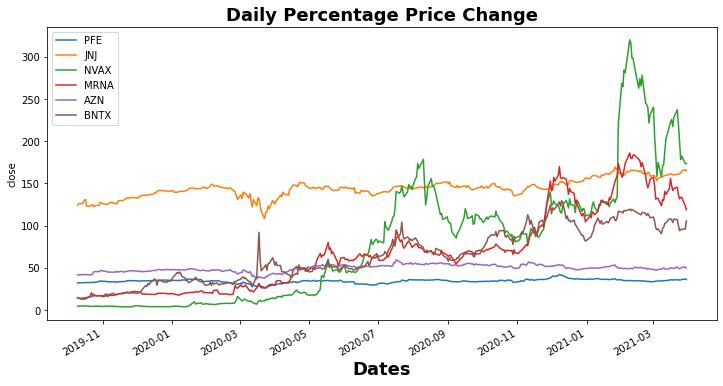

In [134]:
#simple daily return
#centered aroun d 0
plot_delta(multi)

In [135]:
def get_y_from_df(train_scaled_df, look_back, col='PFE', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

#### Train Test Split

In [136]:
train_size = int(len(multi) * 0.80)#0.67
test_size = len(multi) - train_size

In [137]:
multi.index[train_size]

Timestamp('2020-12-11 00:00:00')

In [138]:
multi.index[-test_size]


Timestamp('2020-12-11 00:00:00')

In [139]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot(figsize=(12,8))
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

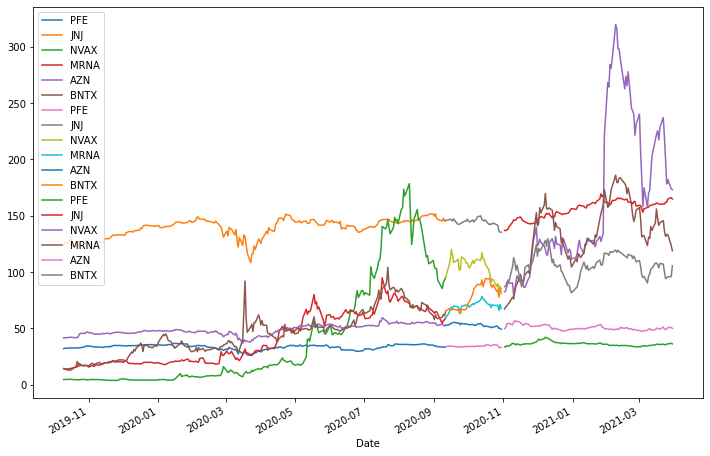

In [140]:
train, val, test= train_test_val(multi)

#### Normalize Data

In [141]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [142]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [143]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [144]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

((233, 6), (36, 6), (102, 6))

In [145]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

{'PFE': 0, 'JNJ': 1, 'NVAX': 2, 'MRNA': 3, 'AZN': 4, 'BNTX': 5}

In [146]:
col_index['PFE']

0

#### Timeseries Generator

In [147]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [148]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='PFE')

In [149]:
# ex_X, ex_y = train_data_gen[0]
# ex_X.shape

In [150]:
sample = ex_X[0]
sample.shape

(3, 6)

In [151]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)               

In [152]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0939 - val_loss: 0.0052
Epoch 2/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0257 - val_loss: 0.0106
Epoch 3/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0184 - val_loss: 0.0033
Epoch 4/25
77/77 [==============================] - 1s 10ms/step - loss: 0.0162 - val_loss: 0.0189
Epoch 5/25
77/77 [==============================] - 1s 10ms/step - loss: 0.0182 - val_loss: 0.0048
Epoch 6/25
77/77 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.0246
Epoch 00006: early stopping


In [153]:
model.evaluate_generator(test_data_gen)

0.0024397640954703093

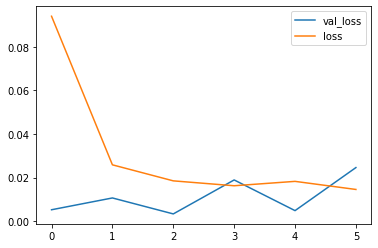

In [154]:
pd.DataFrame(hist.history).plot()

In [155]:
def save_model(model):
    model.save('model_parameters')
    model_params = keras.models.load_model('model_parameters')
    model_params.summary()

    return model_params

In [156]:
# model_params = save_model(model)

In [157]:
trainPredict = model.predict_generator(train_data_gen)
trainPredict.shape

(230, 1)

In [158]:
testPredict = model.predict_generator(test_data_gen)
testPredict.shape

(99, 1)

In [159]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

230

In [160]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

99

In [161]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

#### RMSE Function

In [162]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [163]:
#a value of 0 means predcitions were exact
#models got values exactly as they were supposed to from testing data
#what in normalized
model_metrics(y_train,y_hat_train)

Train Score: 0.10 RMSE
Test Score: 0.12 RMSE


(0.09743447143430828, 0.11707616786402082)

#### Prediction Plot

In [164]:
#red what th model actually predicted
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

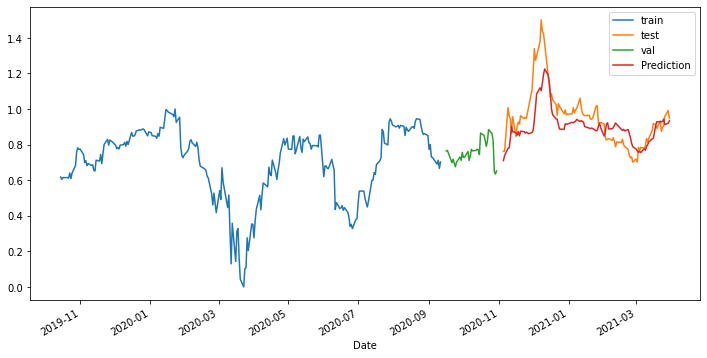

In [165]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM / Single Stock

In [166]:
#df_single.to_csv('single_stock')

# single = pd.read_csv('single_stock', parse_dates=True, index_col='Date')
# single

In [167]:
# pfe_stock_data
pfe_stock_data

Close      Volume  Adj Close
Date                                        
2017-01-03  31.309298  23391844.0  26.653324
2017-01-04  31.584440  22753963.0  26.887548
2017-01-05  31.888046  21083584.0  27.146002
2017-01-06  31.764706  18418228.0  27.041008
2017-01-09  31.755219  21559886.0  27.032928
...               ...         ...        ...
2021-03-24  35.610001  22883400.0  35.610001
2021-03-25  35.669998  24875300.0  35.669998
2021-03-26  36.250000  27897100.0  36.250000
2021-03-29  36.619999  26996000.0  36.619999
2021-03-30  36.145000  12430829.0  36.145000

[1067 rows x 3 columns]

In [168]:
def delta_time_series1(data,col=None):
    data['Actual_Changes'] = data['Close'] - data['Close'].shift(1)
    data['Percent_Chg'] = data[col].pct_change(1)
    data['MA_50'] = data[col].rolling(50).mean()
    data = data.dropna()
    return data

In [169]:
single = delta_time_series1(pfe_stock_data, col='Adj Close')
single

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Close      Volume  Adj Close  Actual_Changes  Percent_Chg  \
Date                                                                        
2017-03-15  32.855785  24279839.0  28.254789        0.388992     0.011981   
2017-03-16  32.666035  21816219.0  28.091606       -0.189751    -0.005775   
2017-03-17  32.561668  45736117.0  28.001856       -0.104366    -0.003195   
2017-03-20  32.618595  18435514.0  28.050808        0.056927     0.001748   
2017-03-21  32.495255  33083479.0  27.944742       -0.123341    -0.003781   
...               ...         ...        ...             ...          ...   
2021-03-24  35.610001  22883400.0  35.610001        0.250000     0.007070   
2021-03-25  35.669998  24875300.0  35.669998        0.059998     0.001685   
2021-03-26  36.250000  27897100.0  36.250000        0.580002     0.016260   
2021-03-29  36.619999  26996000.0  36.619999        0.369999     0.010207   
2021-03-30  36.145000  12430829.0  36.145000       -0.474998    -0.012971   

                MA_50  
Date                   
2017-03-15  26.801835  
2017-03-16  26.830601  
2017-03-17  26.852887  
2017-03-20  26.870983  
2017-03-21  26.889058  
...               ...  
2021-03-24  35.155521  
2021-03-25  35.133324  
2021-03-26  35.129057  
2021-03-29  35.134367  
2021-03-30  35.131166  

[1018 rows x 6 columns]

In [170]:
def get_y_from_df(train_scaled_df, look_back, col='Adj Close', ):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [171]:
train_size = int(len(single) * 0.80)#0.67
test_size = len(single) - train_size

In [172]:
def train_test_val(single_stock, date1='2020-09-11', date2='2020-11-01'):    
    train = single_stock[:date1]#'2020-09-11'
    val = single_stock[date1:date2]
    test = single_stock[date2:] #2021-02-12
    ax = train.plot()
    val.plot(ax=ax)
    test.plot(ax=ax)
    
    return train, val, test

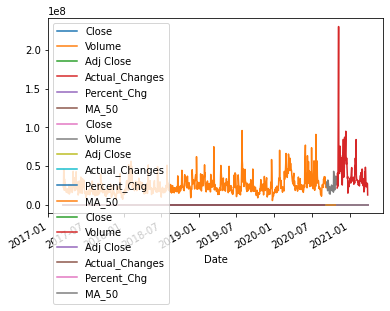

In [173]:
train, val, test= train_test_val(single)

In [174]:
def scale_function(train, test,val):
# normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)
    
    return scaler, train_scaled,test_scaled, val_scaled

In [175]:
scaler, train_scaled, test_scaled, val_scaled = scale_function(train,test,val)

In [176]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns, index=train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test.columns, index=test.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val.columns, index=val.index)

In [177]:
train_scaled_df.shape, val_scaled_df.shape, test_scaled_df.shape

((881, 6), (36, 6), (102, 6))

In [178]:
look_back = 3
batch_size=3
col_index = {v:k for k,v in enumerate(train_scaled_df.columns)}
col_index

{'Close': 0,
 'Volume': 1,
 'Adj Close': 2,
 'Actual_Changes': 3,
 'Percent_Chg': 4,
 'MA_50': 5}

In [179]:
def generator_function(train_scaled_df, val_scaled_df, test_scaled_df, col=None):
    train_data_gen = TimeseriesGenerator(train_scaled_df.values, train_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    val_data_gen = TimeseriesGenerator(val_scaled_df.values, val_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=batch_size)

    test_data_gen = TimeseriesGenerator(test_scaled_df.values, test_scaled_df[col].values,
                                   length=look_back, sampling_rate=1,stride=1,
                                   batch_size=3)
    
    ex_X, ex_y = train_data_gen[0]
    #ex_X.shape
    
    return train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y

In [180]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Adj Close')

In [181]:
sample = ex_X[0]
sample.shape

(3, 6)

In [182]:
model1 = Sequential()

model1.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = True))
model1.add(Dropout(0.2))

model1.add(LSTM(units = 50, return_sequences = False))
model1.add(Dropout(0.2))

model1.add(Dense(units = 25,activation='relu'))
model1.add(Dense(units = 1))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()    

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [183]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model1.fit_generator(train_data_gen, epochs=25,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/25
293/293 [==============================] - 3s 9ms/step - loss: 0.0230 - val_loss: 0.0022
Epoch 2/25
293/293 [==============================] - 3s 10ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 3/25
293/293 [==============================] - 3s 11ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 4/25
293/293 [==============================] - 3s 10ms/step - loss: 0.0055 - val_loss: 0.0150
Epoch 00004: early stopping


In [184]:
model1.evaluate_generator(test_data_gen)

0.0027716748882085085

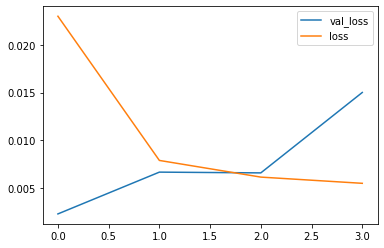

In [185]:
pd.DataFrame(hist.history).plot()

In [186]:
trainPredict = model1.predict_generator(train_data_gen)
trainPredict.shape

(878, 1)

In [187]:
testPredict = model1.predict_generator(test_data_gen)
testPredict.shape

(99, 1)

In [188]:
y_hat_train = pd.Series(trainPredict.flatten(),index=train.index[look_back:])
len(y_hat_train)

878

In [189]:
#y_hat_train = pd.Series(testPredict.
y_hat_test = pd.Series(testPredict.flatten(),index=test.index[look_back:])
len(y_hat_test)

99

In [190]:
y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [191]:
def model_metrics(y_train,y_hat_train):
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train, y_hat_train))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, y_hat_test))
    print('Test Score: %.2f RMSE' % (testScore))
    
    return trainScore, testScore

In [192]:
#what in normalized
model_metrics(y_train,y_hat_train)

Train Score: 0.05 RMSE
Test Score: 0.07 RMSE


(0.04993713143150675, 0.06688696954648889)

In [193]:
def prediction_plot(y_train,y_test,y_val,y_hat_test):
    plt.figure(figsize=(12,6))
    y_train.plot(label='train')
    y_test.plot(label='test')
    y_val.plot(label='val')
    y_hat_test.plot(label='Prediction')
    #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
    plt.legend()
    

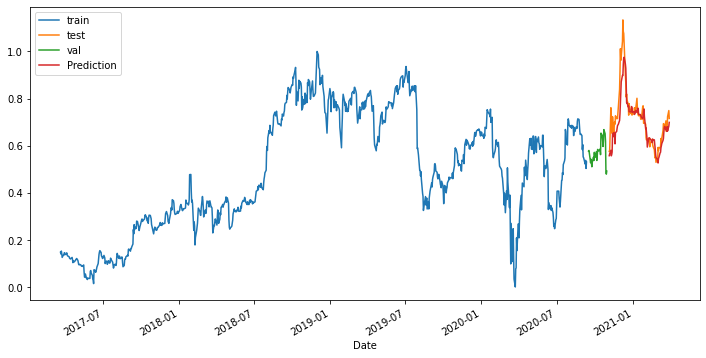

In [194]:
prediction_plot(y_train,y_test,y_val,y_hat_test)

### LTSM and Technical Indicators

#### Moving Average 50 Days

In [195]:
col_index['MA_50']

5

In [196]:
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='MA_50')

In [197]:
sample = ex_X[0]
sample.shape

(3, 6)

In [198]:
model2 = Sequential()

model2.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = True))
model2.add(Dropout(0.2))

model2.add(LSTM(units = 50, return_sequences = False))
model2.add(Dropout(0.2))

model2.add(Dense(units = 25))
model2.add(Dense(units = 1))

model2.compile(optimizer = 'adam', loss = 'mean_squared_error')

model2.summary()    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 50)             11400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 3, 50)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

In [199]:
early_stop = EarlyStopping(monitor='val_loss', patience=3,verbose=True)
# hist = model.fit(X_train,y_train, epochs=10,batch_size=32,callbacks=[early_stop],validation_split=0.1)     
hist = model2.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,callbacks=[early_stop])

Epoch 1/50
293/293 [==============================] - 3s 9ms/step - loss: 0.0330 - val_loss: 0.0029
Epoch 2/50
293/293 [==============================] - 3s 9ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 3/50
293/293 [==============================] - 3s 10ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 4/50
293/293 [==============================] - 5s 16ms/step - loss: 0.0032 - val_loss: 3.8256e-04
Epoch 5/50
293/293 [==============================] - 4s 14ms/step - loss: 0.0022 - val_loss: 7.7361e-04
Epoch 6/50
293/293 [==============================] - 3s 12ms/step - loss: 0.0029 - val_loss: 3.9172e-04
Epoch 7/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 00007: early stopping


In [200]:
model2.evaluate_generator(test_data_gen)

0.0010695374803617597

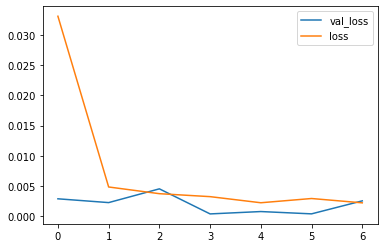

In [201]:
pd.DataFrame(hist.history).plot()

In [202]:
def get_y_from_df(train_scaled_df, look_back, col='MA_50'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

In [203]:
#look_back=3

In [204]:
trainPredict = model2.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model2.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [205]:
model_metrics(y_train,y_hat_train)

Train Score: 0.02 RMSE
Test Score: 0.03 RMSE


(0.02256855225260669, 0.026335565260074266)

In [206]:
model_metrics(y_test,y_hat_test)

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE


(0.026335565260074266, 0.026335565260074266)

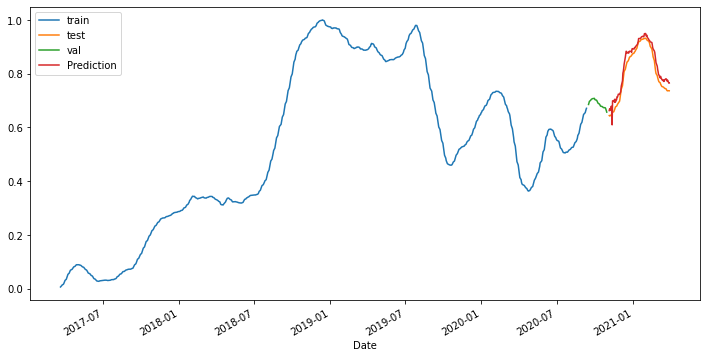

In [207]:
# plt.figure(figsize=(12,6))
# y_train.plot(label='train')
# y_test.plot(label='test')
# y_val.plot(label='val')
# y_hat_test.plot(label='Prediction')
# #lt.legend(['Valid','Train','Predictions'],loc='uppper left')
# plt.legend()
prediction_plot(y_train,y_test,y_val,y_hat_test)

### Actual_Changes

In [208]:
#dollar amount change
train_data_gen,val_data_gen,test_data_gen, ex_X,ex_y = generator_function(train_scaled_df, val_scaled_df,
                                                               test_scaled_df, col='Actual_Changes')

In [209]:
model3 = Sequential()

model3.add(LSTM(units = 50, return_sequences = True, input_shape=sample.shape))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = True))
model3.add(Dropout(0.2))

model3.add(LSTM(units = 50, return_sequences = False))
model3.add(Dropout(0.2))

model3.add(Dense(units = 25, activation='relu'))
model3.add(Dense(units = 1))

model3.compile(optimizer = 'adam', loss = 'mean_squared_error')

model3.summary()    

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 3, 50)             11400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 25)               

In [210]:
hist = model3.fit_generator(train_data_gen, epochs=50,validation_data=val_data_gen,
                           callbacks=[early_stop])

Epoch 1/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0213 - val_loss: 0.0473
Epoch 2/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0109 - val_loss: 0.0517
Epoch 3/50
293/293 [==============================] - 3s 12ms/step - loss: 0.0109 - val_loss: 0.0454
Epoch 4/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0104 - val_loss: 0.0393
Epoch 5/50
293/293 [==============================] - 3s 12ms/step - loss: 0.0103 - val_loss: 0.0382
Epoch 6/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0468
Epoch 7/50
293/293 [==============================] - 4s 13ms/step - loss: 0.0099 - val_loss: 0.0427
Epoch 8/50
293/293 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0387
Epoch 00008: early stopping


In [211]:
model3.evaluate_generator(test_data_gen)

0.01182370912283659

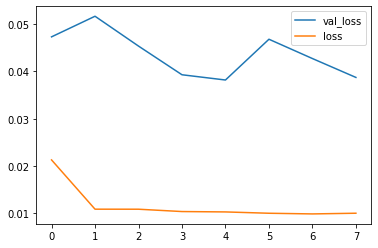

In [212]:
pd.DataFrame(hist.history).plot()

In [213]:
def get_y_from_df(train_scaled_df, look_back, col='Actual_Changes'):
    y = train_scaled_df[col].iloc[look_back: ]
    return y

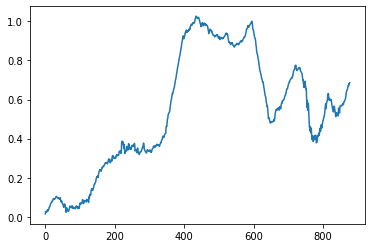

In [214]:
plt.plot(trainPredict)

In [215]:
trainPredict = model3.predict_generator(train_data_gen)
#trainPredict.shape
testPredict = model3.predict_generator(test_data_gen)
#testPredict.shape
y_hat_train = pd.Series(trainPredict.flatten(),index=train_scaled_df.index[look_back:])
y_hat_test = pd.Series(testPredict.flatten(),index=test_scaled_df.index[look_back:])

y_train = get_y_from_df(train_scaled_df,look_back)
y_test = get_y_from_df(test_scaled_df,look_back)
y_train = get_y_from_df(train_scaled_df,look_back)
y_val = get_y_from_df(val_scaled_df,look_back)

In [216]:
model_metrics(y_train,y_hat_train)

Train Score: 0.10 RMSE
Test Score: 0.12 RMSE


(0.10259600160923188, 0.12009223561593892)

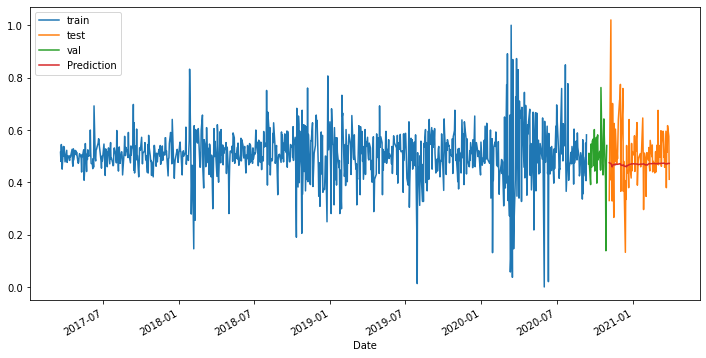

In [217]:
prediction_plot(y_train,y_test,y_val,y_hat_test)